In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm1
from sklearn.model_selection import TimeSeriesSplit


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 데이터셋 로드

data_path = "/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/final_labeled_dataset.csv"

dataset = pd.read_csv(data_path)

dataset = dataset.drop(['Unnamed: 0'], axis=1)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

## 4.3. Feature Engineering

- 가상 화폐 가격에 영향을 미치는 요인 분석
  - (가격 변수) 가격의 움직임을 파악하기 위한 기술적 지표(차트)
  - (수요공급 변수) 가상화폐에 대한 투자 및 공급 수요를 나타내는 지표
  - (심리 변수) 투자자들의 심리를 유추할 수 있는 지표
  - (유동성 지표) 시중에 유통되는 자금의 수준을 나타내는 지표


### 4.3.1. 가격 변수

In [4]:
# 1.지수이동평균선 함수 구현 및 실행(calculation of exponential moving average)

  # 지수이동평균 함수
def EMA(df, n):
    # 지수이동평균선 메서드 - df.ewm(span:기간, min_period: 최소값이 충족되지 않으면 NaN으로 표시).mean() 
    # https://amatoroi.tistory.com/23
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' +str(n))
    return EMA

# 10분, 30분, 180분 이동평균선 생성
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA180'] = EMA(dataset, 180)

# 데이터 확인
dataset.head(10)

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   
5  2021-03-22 21:48:00  2021000  2025000  2021000  2025000   179.342785   
6  2021-03-22 21:49:00  2025000  2050000  2020000  2031000   343.396177   
7  2021-03-22 21:50:00  2030000  2042000  2022000  2030000   176.431125   
8  2021-03-22 21:51:00  2030000  2039000  2024000  2025000   398.874203   
9  2021-03-22 21:52:00  2025000  2035000  2024000  2035000   165.708073   

   signal         EMA10  EMA30  EMA180  
0     NaN           NaN    NaN     NaN  
1     NaN           NaN    NaN     NaN  
2     NaN           NaN    NaN     NaN  
3     NaN           NaN    NaN     NaN  
4     NaN           NaN    NaN     NaN  
5     NaN           NaN    NaN     NaN  
6     NaN           NaN    NaN     NaN  
7     NaN           NaN    NaN     NaN  
8     NaN           NaN    NaN     NaN  
9     NaN  2.030133e+06    NaN     NaN

In [5]:
# 2.ROC 함수 구현 및 실행(#calculation of rate of change)
'''

- 의미
  - 과거 일정한 시점 대비 현재 주가의 변동률
  - 추세 반전을 확인하는 지표로 사용
  - 상승 추세에서는 ROC가 0보다 크며, 하락 추세에서는 0보다 작음

- 수식
  ROC = ((금일 종가 - N일 전 종가) / N일 전 종가) * 100


- (참고자료)https://director-joe.kr/125

'''

# 함수 구현
def ROC(df, n):

    # pandas diff 함수: 특정 간격(periods=1) 행(axis=0) 또는 열(axis=0)의 차이값 계산
      # df.diff(periods= n): 현재 열 - (현재 열-n) 값 출력
      # (참고)https://trading-for-chicken.tistory.com/51
    M = df.diff(n - 1)
    
    # pandas shift 함수: 특정 컬럼의 행 올리기, 내리기
    # df.shift(period = 1): 컬럼의 행 내리기 / 올릴 경우(period = -1)
    # (참고) https://seong6496.tistory.com/216
    N = df.shift(n - 1)

    ROC = pd.Series(((M / N ) * 100), name = 'ROC_' + str(n))
    return ROC


# 10일, 30일 ROC 생성
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)


# 데이터 확인
dataset.tail()


Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180     ROC10     ROC30  
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  1.165944  1.496192  
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  1.003254  1.360544  
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  1.082544  1.549755  
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  1.109908  1.439435  
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  1.001353  1.220504

In [6]:
# 3. 모멘텀(MOM) 함수 구현 및 실행

'''
현재 가격을 여러 기간의 이전 가격과 비교하여 자산 변화율 측정
'''

  # 함수 구현
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' +str(n))
    return MOM


  # 모멘텀 실행
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)


  # 데이터 확인
dataset.tail()

Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180     ROC10     ROC30  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  1.165944  1.496192   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  1.003254  1.360544   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  1.082544  1.549755   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  1.109908  1.439435   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  1.001353  1.220504   

          MOM10    MOM30  
526900  35000.0  58000.0  
526901  37000.0  49000.0  
526902  47000.0  60000.0  
526903  40000.0  57000.0  
526904  38000.0  50000.0

In [7]:
# 4. stochastic osillator(%K and %D) 함수 구현 및 실행

'''
- %K선 의미
  - 특정 기간의 고가/저가 범위 대 특정 기간의 저점 대비 현재 종가의 증가율 사이의 비를 나타내고, 

- %D선(시그널 라인) 
  - 지난 세 번의 기간에 걸친 %K 평균

- %K와 %D 선 계산
  - %k = (전일종가 – 최저가)/(최고가 – 최저가) x 100
  - %D = %K의 3일 SMA

- %K와 %D 선 활용 
  - %K와 %D선이 크로스할 때 매매 시그널이 발생 
  - 두 선은 스토캐스틱 지표의 양단인 0과 100 사이에서 스윙함
  - 80%과 20% 수준을 초과하면 과매수 및 과매도 구간이 됨

- (참고자료) https://phemex.com/ko/academy/stochastic-oscillator-everything-you-need-to-know

'''

# %K 및 $D 함수 구현
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


# 10,30,180분 %K선 및 %D선 실행
dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K180'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 180)
dataset['%D180'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 180)


# 데이터 확인
dataset.tail()



Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180     ROC10     ROC30  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  1.165944  1.496192   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  1.003254  1.360544   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  1.082544  1.549755   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  1.109908  1.439435   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  1.001353  1.220504   

          MOM10    MOM30       %K10       %D10       %K30       %D30  \
526900  35000.0  58000.0  90.000000  95.333333  92.063492  96.388314   
526901  37000.0  49000.0  78.000000  88.000000  81.967213  90.377385   
526902  47000.0  60000.0  98.000000  88.666667  98.360656  90.797120   
526903  40000.0  57000.0  97.727273  91.242424  98.275862  92.867910   
526904  38000.0  50000.0  90.909091  95.545455  92.592593  96.409703   

            %K180      %D180  
526900  95.614035  97.953216  
526901  90.350877  94.736842  
526902  99.122807  95.029240  
526903  99.122807  96.198830  
526904  96.491228  98.245614

In [8]:
# 5.RSI 함수 구현 및 실행

'''

가격 상승 및 하락 추세에서 상승 폭과 하락폭의 강도를 백분율로 계산

'''

  # 함수 구현
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)


  # 10, 30, 180분 RSI 실행
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI180'] = RSI(dataset['Close'], 180)


  # 데이터 확인
dataset.tail()

Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180  ...    MOM30  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  ...  58000.0   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  ...  49000.0   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  ...  60000.0   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  ...  57000.0   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  ...  50000.0   

             %K10       %D10       %K30       %D30      %K180      %D180  \
526900  90.000000  95.333333  92.063492  96.388314  95.614035  97.953216   
526901  78.000000  88.000000  81.967213  90.377385  90.350877  94.736842   
526902  98.000000  88.666667  98.360656  90.797120  99.122807  95.029240   
526903  97.727273  91.242424  98.275862  92.867910  99.122807  96.198830   
526904  90.909091  95.545455  92.592593  96.409703  96.491228  98.245614   

            RSI10      RSI30     RSI180  
526900  82.467768  74.380851  60.339352  
526901  73.423397  70.137244  59.400334  
526902  77.909815  72.811659  60.432339  
526903  77.909815  72.811659  60.432339  
526904  73.325330  70.776694  59.969901  

[5 rows x 23 columns]

In [9]:
#6. 이동평균선 함수 구현 및 실행

def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA


  # 10, 30, 180분 이동평균선 생성
dataset['MA10'] = MA(dataset, 10)
dataset['MA30'] = MA(dataset, 30)
dataset['MA180'] = MA(dataset, 180)


  # 데이터 확인
dataset.tail()

Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180  ...       %K30  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  ...  92.063492   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  ...  81.967213   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  ...  98.360656   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  ...  98.275862   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  ...  92.592593   

             %D30      %K180      %D180      RSI10      RSI30     RSI180  \
526900  96.388314  95.614035  97.953216  82.467768  74.380851  60.339352   
526901  90.377385  90.350877  94.736842  73.423397  70.137244  59.400334   
526902  90.797120  99.122807  95.029240  77.909815  72.811659  60.432339   
526903  92.867910  99.122807  96.198830  77.909815  72.811659  60.432339   
526904  96.409703  96.491228  98.245614  73.325330  70.776694  59.969901   

             MA10          MA30         MA180  
526900  3701400.0  3.692433e+06  3.659017e+06  
526901  3705100.0  3.694067e+06  3.659583e+06  
526902  3709800.0  3.696067e+06  3.660200e+06  
526903  3713800.0  3.697967e+06  3.660822e+06  
526904  3717600.0  3.699633e+06  3.661422e+06  

[5 rows x 26 columns]

In [10]:
# 7. MACD 함수 구현 및 실행

  # 1) MACD : 단기 이평선 값(보통 12일) - 장기 이평선 값(보통 26일)
  # 2) MACD Signal : MACD값의 (보통 9일) 이평선.
  # 3) MACD Histogram : MACD - MACD Signal



def cal_ema_macd(dataset, n_fast=12, n_slow=26, n_signal=9) : 
  dataset["EMAFast"] = dataset["Close"].ewm(span=n_fast).mean() 
  dataset["EMASlow"] = dataset["Close"].ewm(span=n_slow).mean() 
  dataset["MACD"] = dataset["EMAFast"] - dataset["EMASlow"] 
  dataset["MACDSignal"] = dataset["MACD"].ewm(span=n_signal).mean() 
  dataset["MACDDiff"] = dataset["MACD"] - dataset["MACDSignal"] 
  
  return dataset 
  
dataset = cal_ema_macd(dataset)

dataset.tail()

Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180  ...      RSI30  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  ...  74.380851   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  ...  70.137244   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  ...  72.811659   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  ...  72.811659   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  ...  70.776694   

           RSI180       MA10          MA30         MA180       EMAFast  \
526900  60.339352  3701400.0  3.692433e+06  3.659017e+06  3.704896e+06   
526901  59.400334  3705100.0  3.694067e+06  3.659583e+06  3.707989e+06   
526902  60.432339  3709800.0  3.696067e+06  3.660200e+06  3.712144e+06   
526903  60.432339  3713800.0  3.697967e+06  3.660822e+06  3.715661e+06   
526904  59.969901  3717600.0  3.699633e+06  3.661422e+06  3.718174e+06   

             EMASlow          MACD   MACDSignal     MACDDiff  
526900  3.695248e+06   9647.658509  6500.182978  3147.475531  
526901  3.697452e+06  10536.759569  7307.498296  3229.261273  
526902  3.700233e+06  11910.992484  8228.197134  3682.795350  
526903  3.702809e+06  12851.932887  9152.944284  3698.988603  
526904  3.704971e+06  13203.359895  9963.027406  3240.332488  

[5 rows x 31 columns]

In [11]:
# 8. 볼린저밴드 함수 구현 및 실행
  
  # 통계적으로 보면 어떤 분포가 정규분포를 따를때, 평균값을 기준으로 앞 뒤 2 표준편차 이내에 약 95%의 샘플이 존재
  # 1) 중심선 - 이동평균선 (일반적으로 20일선)
  #2) 상한선 - 이동평균선 + 2표준편차
  #3) 하한선 - 이동평균선 - 2표준편차

def cal_bb(stock, w=20, k=2) : 
  x = pd.Series(stock) 
  mbb = x.rolling(w).mean()  # 중심선
  hbb = mbb + k * x.rolling(w).std() # 상한선
  lbb = mbb - k * x.rolling(w).std() # 하한선
  
  return mbb, hbb, lbb 
  
dataset["MBB(MA20)"], dataset["HBB"], dataset["LBB"] = cal_bb(dataset["Close"])
dataset.tail()


Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180  ...          MA30  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  ...  3.692433e+06   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  ...  3.694067e+06   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  ...  3.696067e+06   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  ...  3.697967e+06   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  ...  3.699633e+06   

               MA180       EMAFast       EMASlow          MACD   MACDSignal  \
526900  3.659017e+06  3.704896e+06  3.695248e+06   9647.658509  6500.182978   
526901  3.659583e+06  3.707989e+06  3.697452e+06  10536.759569  7307.498296   
526902  3.660200e+06  3.712144e+06  3.700233e+06  11910.992484  8228.197134   
526903  3.660822e+06  3.715661e+06  3.702809e+06  12851.932887  9152.944284   
526904  3.661422e+06  3.718174e+06  3.704971e+06  13203.359895  9963.027406   

           MACDDiff  MBB(MA20)           HBB           LBB  
526900  3147.475531  3696700.0  3.722387e+06  3.671013e+06  
526901  3229.261273  3698500.0  3.726825e+06  3.670175e+06  
526902  3682.795350  3700800.0  3.733073e+06  3.668527e+06  
526903  3698.988603  3703100.0  3.738259e+06  3.667941e+06  
526904  3240.332488  3705250.0  3.742002e+06  3.668498e+06  

[5 rows x 34 columns]

In [12]:
# 9. ADX,DMI 함수 구현 및 실행
''' 
  # DM (Directional Movement)
   # 상승 추세 일때는 금일의 고가가 반드시 전일의 고가 보다 높아야 하고, 하락 추세 일때는 금일의 저가가 반드시 전일의 저가 보다 낮아야 한다고 가정하고 계산합니다.
    # 전일의 고가 보다 금일의 고가가 높을시 : +DM
    # 전일의 저가 보다 금일의 저가가 낮을시 : -DM
    # 위 상황이 둘다 발생했을 때,
     # 고가 상승 범위가 더 크다면 : +DM
     # 저가 하락 범위가 더 크다면 : -DM
    # 변동 자체가 전날의 변동보다 작다면 : DM = 0

  # TR (True Range)
   #아래의 세가지 경우 중 절대값이 가장 큰 값을 TR로 지정합니다.
    # 1. 금일의 고가 - 금일의 저가
    # 2. 금일의 고가 - 전일의 종가
    # 3. 금일의 저가 - 전일의 종가

  # DI(Directional Indicator)
   # DI = DM / TR
   # DI는 DM의 값에 따라 부호가 바뀌게 됨.
   # DM과 TR 하루치를 통해 DI를 계산하는게 아니라, 보통 M일 동안의 이동평균으로 계산
   # +DI = +DM의 M일 이동평균 / TR의 M일 이동평균
           # = DI Plus
           # = PDI
   # -DI = -DM의 M일 이동평균 / TR의 M일 이동평균
           # = DI Minus
           # MDI

   # 이렇게 계산된 DI는 M일 동안 상승 추세, 또는 하락 추세에서 금일 주가의 비율

   # 즉 DI Plus가 위에 있다면 상승 추세에 있다고 볼 수 있고, DI Minus가 더 위에 있다면 하락 추세
  
   # PDI가 MDI를 상향 돌파하는 골든 크로스에 매수 포지션

   # PDI가 MDI를 하향 돌파하는 데드 크로스에 매도 포지션

   # DMI 지수는 가짜 신호가 꽤 많고, 신호 자체도 자주 일어나, ADX와 같이 많이 활용

   # ADX = | (PDI - MDI) | / (PDI + MDI) * 100

   # ADX는 현재 추세의 강한 정도를 나타냅니다. 그 추세가 상승 추세인지, 하락 추세인지는 모름 그래서 DMI와 함께사용

   # PDI가 DMI를 상향 돌파하는 골든 크로스 상황에서, ADX의 크기도 커지고 있다면 상승 추세가 높아진다고 예상 할 수 있습니다. 그럴 경우에 강한 매수 신호로 볼 수 있습니다. DMI의 의미 없는 신호를 거를 수 있게 됨.

'''

 # 일봉데이터만 사용해서 하려고 했는데 보면 이동평균선도 10분 60분 사용한 것 처럼 ADX,DMI지표도 분으로 해서 확인해도 괜찮을 것 같습니다 ! 


def cal_dmi(dataset, n=14, n_ADX=14): #14일 이동평균으로 계산(분봉데이터라 14분으로 보면 될 것 같습니다)
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= dataset.index[-1]:
        UpMove = dataset.loc[i + 1, 'High'] - dataset.loc[i, 'High']
        DoMove = dataset.loc[i, 'Low'] - dataset.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < dataset.index[-1]:
        TR = max(dataset.loc[i + 1, 'High'], dataset.loc[i, 'Close']) - min(dataset.loc[i + 1, 'Low'], dataset.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=1).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
  

    return PosDI, NegDI, ADX

dataset["PDI"],dataset["MDI"],dataset["ADX"] = cal_dmi(dataset)

dataset.tail()

Date     Open     High      Low    Close      Volume  \
526900  2022-03-24 00:14:00  3734000  3734000  3724000  3731000  229.575891   
526901  2022-03-24 00:15:00  3732000  3732000  3725000  3725000  123.917596   
526902  2022-03-24 00:16:00  3725000  3735000  3722000  3735000  113.032986   
526903  2022-03-24 00:17:00  3734000  3736000  3732000  3735000   72.041628   
526904  2022-03-24 00:18:00  3734000  3736000  3732000  3732000  124.442686   

        signal         EMA10         EMA30        EMA180  ...       EMASlow  \
526900     NaN  3.707092e+06  3.693219e+06  3.663236e+06  ...  3.695248e+06   
526901     NaN  3.710348e+06  3.695269e+06  3.663919e+06  ...  3.697452e+06   
526902     NaN  3.714830e+06  3.697833e+06  3.664704e+06  ...  3.700233e+06   
526903     NaN  3.718497e+06  3.700230e+06  3.665481e+06  ...  3.702809e+06   
526904     NaN  3.720952e+06  3.702280e+06  3.666216e+06  ...  3.704971e+06   

                MACD   MACDSignal     MACDDiff  MBB(MA20)           HBB  \
526900   9647.658509  6500.182978  3147.475531  3696700.0  3.722387e+06   
526901  10536.759569  7307.498296  3229.261273  3698500.0  3.726825e+06   
526902  11910.992484  8228.197134  3682.795350  3700800.0  3.733073e+06   
526903  12851.932887  9152.944284  3698.988603  3703100.0  3.738259e+06   
526904  13203.359895  9963.027406  3240.332488  3705250.0  3.742002e+06   

                 LBB       PDI       MDI       ADX  
526900  3.671013e+06  0.598777  0.060659  0.435828  
526901  3.670175e+06  0.533042  0.054000  0.486521  
526902  3.668527e+06  0.431528  0.043716  0.530455  
526903  3.667941e+06  0.420031  0.040947  0.569374  
526904  3.668498e+06  0.391428  0.038159  0.603104  

[5 rows x 37 columns]

In [13]:
# 10. 전일 종가 대비 시가 비율
'''

전일 종가 대비 당일 시가 비율 (open/last close)
  - 당일 시가를 전일 종가로 나눈 값
  - 주로 전일 종가에 비해 당일 시가가 상당히 높으면 '갭상승'이라 함
  - 반대로 전일 종가보다 당일 시가가 많이 떨어져 있으면 '갭하락'이라 부름

'''

# 함수 구현
def open_lastclose_ratio(df_open, df_last_close):
    OLCR = pd.Series(df_open / df_last_close)
    return OLCR

# 함수 실행
dataset['OLCR'] = open_lastclose_ratio(dataset['Open'], dataset['Close'].shift(1))

dataset.head()



Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...         MACD   MACDSignal    MACDDiff  \
0     NaN    NaN    NaN     NaN  ...     0.000000     0.000000    0.000000   
1     NaN    NaN    NaN     NaN  ...  -673.076923  -373.931624 -299.145299   
2     NaN    NaN    NaN     NaN  ... -1663.892041  -902.603926 -761.288115   
3     NaN    NaN    NaN     NaN  ... -2145.965649 -1323.796922 -822.168727   
4     NaN    NaN    NaN     NaN  ... -2243.362354 -1597.346848 -646.015506   

   MBB(MA20)  HBB  LBB  PDI  MDI  ADX      OLCR  
0        NaN  NaN  NaN  NaN  NaN  NaN       NaN  
1        NaN  NaN  NaN  NaN  NaN  NaN  0.997592  
2        NaN  NaN  NaN  NaN  NaN  NaN  0.999511  
3        NaN  NaN  NaN  NaN  NaN  NaN  0.999010  
4        NaN  NaN  NaN  NaN  NaN  NaN  1.000000  

[5 rows x 38 columns]

In [14]:
# 11. 당일 종가 대비 당일 고가 비율

'''

- 당일 종가 대비 당일 고가 비율 (high/close)
  - 당일 고가를 당일 종가로 나눈 값
  - 이 값만으로는 추세를 예측할 수는 없지만, 학습 데이터의 특징으로 가치가 있음
  - 당일 고가가 종가에 비해 상당히 높다면 많은 경우에 저항선을 뚫지 못해서 추가적인 상승이 어렵다고 판단
  - 이를 '일봉의 위꼬리가 길다'라고도 표현함

'''

# 함수 구현
def high_close_ratio(df_high, df_close):
    HCR = pd.Series(df_high / df_close)
    return HCR

# 함수 실행
dataset['HCR'] = high_close_ratio(dataset['High'], dataset['Close'])

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...   MACDSignal    MACDDiff  MBB(MA20)  HBB  \
0     NaN    NaN    NaN     NaN  ...     0.000000    0.000000        NaN  NaN   
1     NaN    NaN    NaN     NaN  ...  -373.931624 -299.145299        NaN  NaN   
2     NaN    NaN    NaN     NaN  ...  -902.603926 -761.288115        NaN  NaN   
3     NaN    NaN    NaN     NaN  ... -1323.796922 -822.168727        NaN  NaN   
4     NaN    NaN    NaN     NaN  ... -1597.346848 -646.015506        NaN  NaN   

   LBB  PDI  MDI  ADX      OLCR       HCR  
0  NaN  NaN  NaN  NaN       NaN  1.008671  
1  NaN  NaN  NaN  NaN  0.997592  1.027370  
2  NaN  NaN  NaN  NaN  0.999511  1.012376  
3  NaN  NaN  NaN  NaN  0.999010  1.003469  
4  NaN  NaN  NaN  NaN  1.000000  1.001979  

[5 rows x 39 columns]

In [15]:
# 12. 당일 종가 대비 당일 저가 비율
'''

- 당일 종가 대비 당일 저가 비율 (low/close)
  - 당일 저가를 당일 종가로 나눈 값
  - 당일 저가보다 당일 종가가 더 낮으면 지지선이 하향돌파될 우려가 있음

'''

# 함수 구현
def low_close_ratio(df_low, df_close):
    LCR = pd.Series(df_low / df_close)
    return LCR

# 함수 실행
dataset['LCR'] = low_close_ratio(dataset['Low'], dataset['Close'])

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...    MACDDiff  MBB(MA20)  HBB  LBB  PDI  \
0     NaN    NaN    NaN     NaN  ...    0.000000        NaN  NaN  NaN  NaN   
1     NaN    NaN    NaN     NaN  ... -299.145299        NaN  NaN  NaN  NaN   
2     NaN    NaN    NaN     NaN  ... -761.288115        NaN  NaN  NaN  NaN   
3     NaN    NaN    NaN     NaN  ... -822.168727        NaN  NaN  NaN  NaN   
4     NaN    NaN    NaN     NaN  ... -646.015506        NaN  NaN  NaN  NaN   

   MDI  ADX      OLCR       HCR       LCR  
0  NaN  NaN       NaN  1.008671  0.997592  
1  NaN  NaN  0.997592  1.027370  0.999511  
2  NaN  NaN  0.999511  1.012376  0.999010  
3  NaN  NaN  0.999010  1.003469  0.999504  
4  NaN  NaN  1.000000  1.001979  0.998516  

[5 rows x 40 columns]

In [16]:
# 13. 전일 종가 대비 당일 종가 비율
'''

- 전일 종가 대비 당일 종가 비율 (close/last close)
  - 당일 종가를 전일 종가로 나눈 값
  - 일반적으로 주가가 올랐다, 떨어졌다를 얘기할 때 당일 종가에서 전일 종가를 뺀 다음에 다시 전일 종가로 나눔
  - 수식으로는 (close–last close/last close)가 됨
  - 같은 의미지만, 학습 데이터에는 비율 값으로 사용함


'''

# 함수 정의
def close_lastclose_ratio(df_close, df_last_close):
    CLCR = pd.Series(df_close / df_last_close)
    return CLCR

# 함수 실행
dataset['CLCR'] = close_lastclose_ratio(dataset['Close'], dataset['Close'].shift(1))

dataset.head()




Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...  MBB(MA20)  HBB  LBB  PDI  MDI  ADX  \
0     NaN    NaN    NaN     NaN  ...        NaN  NaN  NaN  NaN  NaN  NaN   
1     NaN    NaN    NaN     NaN  ...        NaN  NaN  NaN  NaN  NaN  NaN   
2     NaN    NaN    NaN     NaN  ...        NaN  NaN  NaN  NaN  NaN  NaN   
3     NaN    NaN    NaN     NaN  ...        NaN  NaN  NaN  NaN  NaN  NaN   
4     NaN    NaN    NaN     NaN  ...        NaN  NaN  NaN  NaN  NaN  NaN   

       OLCR       HCR       LCR      CLCR  
0       NaN  1.008671  0.997592       NaN  
1  0.997592  1.027370  0.999511  0.985549  
2  0.999511  1.012376  0.999010  0.987292  
3  0.999010  1.003469  0.999504  0.999010  
4  1.000000  1.001979  0.998516  1.001487  

[5 rows x 41 columns]

In [17]:
# 14. 전일 거래량 대비 당일 거래량 비율
'''

- 전일 거래량 대비 당일 거래량 비율 (volume/last volume)
  - 당일 거래량를 전일 거래량으로 나눈 값
  - 주가가 상승하면서 거래량이 늘면 주가 상승에 긍정적인 신호로 여김
  - 이를 포착하고자 이 값을 학습 데이터의 특징으로 추가

'''

# 함수 정의
def volume_lastvolume_ratio(df_volume, df_last_volume):
    VLVR = pd.Series(df_volume / df_last_volume)
    return VLVR

# 함수 실행
dataset['VLVR'] = volume_lastvolume_ratio(dataset['Volume'], dataset['Volume'].shift(1))

dataset.head()






Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...  HBB  LBB  PDI  MDI  ADX      OLCR  \
0     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN       NaN   
1     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  0.997592   
2     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  0.999511   
3     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  0.999010   
4     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  1.000000   

        HCR       LCR      CLCR      VLVR  
0  1.008671  0.997592       NaN       NaN  
1  1.027370  0.999511  0.985549  8.145812  
2  1.012376  0.999010  0.987292  0.452218  
3  1.003469  0.999504  0.999010  0.311135  
4  1.001979  0.998516  1.001487  1.425452  

[5 rows x 42 columns]

In [18]:
# 15. 5일 평균 종가 대비 당일 종가 비율 (close/MA5 close) 

'''

- 5일 평균 종가 대비 당일 종가 비율 (close/MA5 close)
  - 당일 종가를 5일 동안의 평균 종가로 나눈 값
  - 단기 주가 추세를 학습 데이터 특징으로 고려하기 위해 사용


'''

# 함수 생성
def close_maclose_ratio(df_close, n):
    MA = df_close.rolling(n, min_periods=n).mean()

    CMAR = pd.Series(df_close / MA)

    return CMAR


# 함수 실행
dataset['CMA5R'] = close_maclose_ratio(dataset['Close'], 5)

dataset.head(5)








Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...  LBB  PDI  MDI  ADX      OLCR       HCR  \
0     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN       NaN  1.008671   
1     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  0.997592  1.027370   
2     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  0.999511  1.012376   
3     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  0.999010  1.003469   
4     NaN    NaN    NaN     NaN  ...  NaN  NaN  NaN  NaN  1.000000  1.001979   

        LCR      CLCR      VLVR     CMA5R  
0  0.997592       NaN       NaN       NaN  
1  0.999511  0.985549  8.145812       NaN  
2  0.999010  0.987292  0.452218       NaN  
3  0.999504  0.999010  0.311135       NaN  
4  0.998516  1.001487  1.425452  0.992535  

[5 rows x 43 columns]

In [19]:
# 16. 10일 평균 종가 대비 당일 종가 비율 (close/MA10 close) 
'''

- 10일 평균 종가 대비 당일 종가 비율 (close/MA10 close)
- 당일 종가를 10일 동안의 평균 종가로 나눈 값 
- 마찬가지로 단기 주가 추세를 고려하기 위함

'''

# 함수 실행
dataset['CMA10R'] = close_maclose_ratio(dataset['Close'], 10)

dataset.head(10)

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   
5  2021-03-22 21:48:00  2021000  2025000  2021000  2025000   179.342785   
6  2021-03-22 21:49:00  2025000  2050000  2020000  2031000   343.396177   
7  2021-03-22 21:50:00  2030000  2042000  2022000  2030000   176.431125   
8  2021-03-22 21:51:00  2030000  2039000  2024000  2025000   398.874203   
9  2021-03-22 21:52:00  2025000  2035000  2024000  2035000   165.708073   

   signal         EMA10  EMA30  EMA180  ...  PDI  MDI  ADX      OLCR  \
0     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN       NaN   
1     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  0.997592   
2     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  0.999511   
3     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  0.999010   
4     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  1.000000   
5     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  1.000000   
6     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  1.000000   
7     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  0.999508   
8     NaN           NaN    NaN     NaN  ...  NaN  NaN  NaN  1.000000   
9     NaN  2.030133e+06    NaN     NaN  ...  NaN  NaN  NaN  1.000000   

        HCR       LCR      CLCR      VLVR     CMA5R    CMA10R  
0  1.008671  0.997592       NaN       NaN       NaN       NaN  
1  1.027370  0.999511  0.985549  8.145812       NaN       NaN  
2  1.012376  0.999010  0.987292  0.452218       NaN       NaN  
3  1.003469  0.999504  0.999010  0.311135       NaN       NaN  
4  1.001979  0.998516  1.001487  1.425452  0.992535       NaN  
5  1.000000  0.998025  1.001979  0.377500  0.999506       NaN  
6  1.009355  0.994584  1.002963  1.914748  1.003955       NaN  
7  1.005911  0.996059  0.999508  0.513783  1.002469       NaN  
8  1.006914  0.999506  0.997537  2.260793  0.999309       NaN  
9  1.000000  0.994595  1.004938  0.415439  1.002858  1.001131  

[10 rows x 44 columns]

In [20]:
# 17. 20일 평균 종가 대비 당일 종가 비율 (close/MA20 close)
'''

- 20일 평균 종가 대비 당일 종가 비율 (close/MA20 close)
- 당일 종가를 20일 동안의 평균 종가로 나눈 값
- 20일선은 주가 추세를 잘 보여주는 이동평균선

'''

dataset['CMA20R'] = close_maclose_ratio(dataset['Close'], 20)

dataset.head(20)

Date     Open     High      Low    Close       Volume  \
0   2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1   2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2   2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3   2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4   2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   
5   2021-03-22 21:48:00  2021000  2025000  2021000  2025000   179.342785   
6   2021-03-22 21:49:00  2025000  2050000  2020000  2031000   343.396177   
7   2021-03-22 21:50:00  2030000  2042000  2022000  2030000   176.431125   
8   2021-03-22 21:51:00  2030000  2039000  2024000  2025000   398.874203   
9   2021-03-22 21:52:00  2025000  2035000  2024000  2035000   165.708073   
10  2021-03-22 21:53:00  2035000  2039000  2027000  2027000   424.663335   
11  2021-03-22 21:54:00  2027000  2029000  2019000  2019000   470.841579   
12  2021-03-22 21:55:00  2019000  2020000  2013000  2014000   339.689469   
13  2021-03-22 21:56:00  2014000  2015000  2012000  2014000   181.280343   
14  2021-03-22 21:57:00  2014000  2015000  2012000  2012000   170.045700   
15  2021-03-22 21:58:00  2012000  2013000  2011000  2011000   255.985368   
16  2021-03-22 21:59:00  2011000  2013000  2010000  2011000   257.288034   
17  2021-03-22 22:00:00  2010000  2024000  2009000  2013000   348.201138   
18  2021-03-22 22:01:00  2011000  2024000  2005000  2008000   366.896183   
19  2021-03-22 22:02:00  2009000  2010000  2002000  2002000   295.995453   

    signal         EMA10  EMA30  EMA180  ...       MDI       ADX      OLCR  \
0      NaN           NaN    NaN     NaN  ...       NaN       NaN       NaN   
1      NaN           NaN    NaN     NaN  ...       NaN       NaN  0.997592   
2      NaN           NaN    NaN     NaN  ...       NaN       NaN  0.999511   
3      NaN           NaN    NaN     NaN  ...       NaN       NaN  0.999010   
4      NaN           NaN    NaN     NaN  ...       NaN       NaN  1.000000   
5      NaN           NaN    NaN     NaN  ...       NaN       NaN  1.000000   
6      NaN           NaN    NaN     NaN  ...       NaN       NaN  1.000000   
7      NaN           NaN    NaN     NaN  ...       NaN       NaN  0.999508   
8      NaN           NaN    NaN     NaN  ...       NaN       NaN  1.000000   
9      NaN  2.030133e+06    NaN     NaN  ...       NaN       NaN  1.000000   
10     NaN  2.029493e+06    NaN     NaN  ...       NaN       NaN  1.000000   
11     NaN  2.027396e+06    NaN     NaN  ...       NaN       NaN  1.000000   
12     NaN  2.024767e+06    NaN     NaN  ...       NaN       NaN  1.000000   
13     NaN  2.022684e+06    NaN     NaN  ...  0.289033  0.316724  1.000000   
14     NaN  2.020641e+06    NaN     NaN  ...  0.276838  0.316724  1.000000   
15     NaN  2.018814e+06    NaN     NaN  ...  0.283853  0.326423  1.000000   
16     NaN  2.017345e+06    NaN     NaN  ...  0.286406  0.339498  1.000000   
17     NaN  2.016533e+06    NaN     NaN  ...  0.220702  0.277098  0.999503   
18     NaN  2.014947e+06    NaN     NaN  ...  0.218147  0.221792  0.999006   
19     NaN  2.012549e+06    NaN     NaN  ...  0.235201  0.202976  1.000498   

         HCR       LCR      CLCR      VLVR     CMA5R    CMA10R    CMA20R  
0   1.008671  0.997592       NaN       NaN       NaN       NaN       NaN  
1   1.027370  0.999511  0.985549  8.145812       NaN       NaN       NaN  
2   1.012376  0.999010  0.987292  0.452218       NaN       NaN       NaN  
3   1.003469  0.999504  0.999010  0.311135       NaN       NaN       NaN  
4   1.001979  0.998516  1.001487  1.425452  0.992535       NaN       NaN  
5   1.000000  0.998025  1.001979  0.377500  0.999506       NaN       NaN  
6   1.009355  0.994584  1.002963  1.914748  1.003955       NaN       NaN  
7   1.005911  0.996059  0.999508  0.513783  1.002469       NaN       NaN  
8   1.006914  0.999506  0.997537  2.260793  0.999309       NaN       NaN  
9   1.000000  0.994595  1.004938 

In [21]:
# 18. 60일 평균 종가 대비 당일 종가 비율 (close/MA60 close)

'''

- 60일 평균 종가 대비 당일 종가 비율 (close/MA60 close)
- 당일 종가를 60일 동안의 평균 종가로 나눈 값
- 60일선 역시 대표적인 이동평균선
- 20일선이 60일선을 상향 돌파하면 골든 크로스(golden cross)라고 부를 정도로 의미 있는 이동평균선


'''

dataset['CMA60R'] = close_maclose_ratio(dataset['Close'], 60)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...  ADX      OLCR       HCR       LCR  \
0     NaN    NaN    NaN     NaN  ...  NaN       NaN  1.008671  0.997592   
1     NaN    NaN    NaN     NaN  ...  NaN  0.997592  1.027370  0.999511   
2     NaN    NaN    NaN     NaN  ...  NaN  0.999511  1.012376  0.999010   
3     NaN    NaN    NaN     NaN  ...  NaN  0.999010  1.003469  0.999504   
4     NaN    NaN    NaN     NaN  ...  NaN  1.000000  1.001979  0.998516   

       CLCR      VLVR     CMA5R  CMA10R  CMA20R  CMA60R  
0       NaN       NaN       NaN     NaN     NaN     NaN  
1  0.985549  8.145812       NaN     NaN     NaN     NaN  
2  0.987292  0.452218       NaN     NaN     NaN     NaN  
3  0.999010  0.311135       NaN     NaN     NaN     NaN  
4  1.001487  1.425452  0.992535     NaN     NaN     NaN  

[5 rows x 46 columns]

In [22]:
# 19. 120일 평균 종가 대비 당일 종가 비율 (close/MA20 close)

'''

- 120일 평균 종가 대비 당일 종가 비율 (close/MA20 close)
- 당일 종가를 120일 동안의 평균 종가로 나눈 값
- 120일은 주식 거래일 기준 약 6개월에 해당하는 기간
- 이 값은 중·장기간의 평균값 대비 당일 종가의 위치를 의미

'''

dataset['CMA120R'] = close_maclose_ratio(dataset['Close'], 120)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...      OLCR       HCR       LCR      CLCR  \
0     NaN    NaN    NaN     NaN  ...       NaN  1.008671  0.997592       NaN   
1     NaN    NaN    NaN     NaN  ...  0.997592  1.027370  0.999511  0.985549   
2     NaN    NaN    NaN     NaN  ...  0.999511  1.012376  0.999010  0.987292   
3     NaN    NaN    NaN     NaN  ...  0.999010  1.003469  0.999504  0.999010   
4     NaN    NaN    NaN     NaN  ...  1.000000  1.001979  0.998516  1.001487   

       VLVR     CMA5R  CMA10R  CMA20R  CMA60R  CMA120R  
0       NaN       NaN     NaN     NaN     NaN      NaN  
1  8.145812       NaN     NaN     NaN     NaN      NaN  
2  0.452218       NaN     NaN     NaN     NaN      NaN  
3  0.311135       NaN     NaN     NaN     NaN      NaN  
4  1.425452  0.992535     NaN     NaN     NaN      NaN  

[5 rows x 47 columns]

In [23]:
# 20. 5일 평균 거래량 대비 당일 거래량 비율 (volume/MA5 volume)

'''

- 5일 평균 거래량 대비 당일 거래량 비율 (volume/MA5 volume)
  - 당일 거래량을 5일 동안의 평균 거래량으로 나눈 값 
  - 단기적인 거래량 추세를 수치화한 것입니다. 
  - 거래량이 증가하고 있다면 주가의 추세를 유지할 가능성이 높다고 기대할 수 있음
  - 주가가 상승하고 있는데 거래량도 늘고 있다면 주가가 더 상승할 가능성이 높다는 의미
  - 반대로 주가가 하락하고 있는데 거래량이 늘고 있으면 주가가 더 떨어질 가능성이 높다는 것

'''

# 함수 생성
def volume_mavolume_ratio(df_volume, n):
    MA = df_volume.rolling(n, min_periods=n).mean()

    VMAR = pd.Series(df_volume / MA)

    return VMAR


# 함수 실행
dataset['VMA5R'] = close_maclose_ratio(dataset['Volume'], 5)

dataset.head()


Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...       HCR       LCR      CLCR      VLVR  \
0     NaN    NaN    NaN     NaN  ...  1.008671  0.997592       NaN       NaN   
1     NaN    NaN    NaN     NaN  ...  1.027370  0.999511  0.985549  8.145812   
2     NaN    NaN    NaN     NaN  ...  1.012376  0.999010  0.987292  0.452218   
3     NaN    NaN    NaN     NaN  ...  1.003469  0.999504  0.999010  0.311135   
4     NaN    NaN    NaN     NaN  ...  1.001979  0.998516  1.001487  1.425452   

      CMA5R  CMA10R  CMA20R  CMA60R  CMA120R     VMA5R  
0       NaN     NaN     NaN     NaN      NaN       NaN  
1       NaN     NaN     NaN     NaN      NaN       NaN  
2       NaN     NaN     NaN     NaN      NaN       NaN  
3       NaN     NaN     NaN     NaN      NaN       NaN  
4  0.992535     NaN     NaN     NaN      NaN  0.523322  

[5 rows x 48 columns]

In [24]:
# 21. 10일 평균 거래량 대비 당일 거래량 비율 (volume/MA10 volume)

'''

- 10일 평균 거래량 대비 당일 거래량 비율 (volume/MA10 volume)
  - 당일 거래량을 10일 동안의 평균 거래량으로 나눈 값
  - 단기적인 거래량 추세를 내포

'''

# 함수 실행
dataset['VMA10R'] = close_maclose_ratio(dataset['Volume'], 10)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...       LCR      CLCR      VLVR     CMA5R  \
0     NaN    NaN    NaN     NaN  ...  0.997592       NaN       NaN       NaN   
1     NaN    NaN    NaN     NaN  ...  0.999511  0.985549  8.145812       NaN   
2     NaN    NaN    NaN     NaN  ...  0.999010  0.987292  0.452218       NaN   
3     NaN    NaN    NaN     NaN  ...  0.999504  0.999010  0.311135       NaN   
4     NaN    NaN    NaN     NaN  ...  0.998516  1.001487  1.425452  0.992535   

   CMA10R  CMA20R  CMA60R  CMA120R     VMA5R  VMA10R  
0     NaN     NaN     NaN      NaN       NaN     NaN  
1     NaN     NaN     NaN      NaN       NaN     NaN  
2     NaN     NaN     NaN      NaN       NaN     NaN  
3     NaN     NaN     NaN      NaN       NaN     NaN  
4     NaN     NaN     NaN      NaN  0.523322     NaN  

[5 rows x 49 columns]

In [25]:
# 22. 20일 평균 거래량 대비 당일 거래량 비율 (volume/MA20 volume) 

'''

- 20일 평균 거래량 대비 당일 거래량 비율 (volume/MA20 volume) 
- 당일 거래량을 20일 동안의 평균 거래량으로 나눈 값
- 거래량 역시 20일 이동평균선은 중요한 의미를 지님

'''

# 함수 실행
dataset['VMA20R'] = close_maclose_ratio(dataset['Volume'], 20)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...      CLCR      VLVR     CMA5R  CMA10R  \
0     NaN    NaN    NaN     NaN  ...       NaN       NaN       NaN     NaN   
1     NaN    NaN    NaN     NaN  ...  0.985549  8.145812       NaN     NaN   
2     NaN    NaN    NaN     NaN  ...  0.987292  0.452218       NaN     NaN   
3     NaN    NaN    NaN     NaN  ...  0.999010  0.311135       NaN     NaN   
4     NaN    NaN    NaN     NaN  ...  1.001487  1.425452  0.992535     NaN   

   CMA20R  CMA60R  CMA120R     VMA5R  VMA10R  VMA20R  
0     NaN     NaN      NaN       NaN     NaN     NaN  
1     NaN     NaN      NaN       NaN     NaN     NaN  
2     NaN     NaN      NaN       NaN     NaN     NaN  
3     NaN     NaN      NaN       NaN     NaN     NaN  
4     NaN     NaN      NaN  0.523322     NaN     NaN  

[5 rows x 50 columns]

In [26]:
# 23. 60일 평균 거래량 대비 당일 거래량 비율 (volume/MA60 volume)

'''

- 60일 평균 거래량 대비 당일 거래량 비율 (volume/MA60 volume)
  - 당일 거래량을 60일 동안의 평균 거래량으로 나눈 값
  - 중기적인 추세를 볼 수 있는 지표

'''

# 함수 실행
dataset['VMA60R'] = close_maclose_ratio(dataset['Volume'], 60)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...      VLVR     CMA5R  CMA10R  CMA20R  \
0     NaN    NaN    NaN     NaN  ...       NaN       NaN     NaN     NaN   
1     NaN    NaN    NaN     NaN  ...  8.145812       NaN     NaN     NaN   
2     NaN    NaN    NaN     NaN  ...  0.452218       NaN     NaN     NaN   
3     NaN    NaN    NaN     NaN  ...  0.311135       NaN     NaN     NaN   
4     NaN    NaN    NaN     NaN  ...  1.425452  0.992535     NaN     NaN   

   CMA60R  CMA120R     VMA5R  VMA10R  VMA20R  VMA60R  
0     NaN      NaN       NaN     NaN     NaN     NaN  
1     NaN      NaN       NaN     NaN     NaN     NaN  
2     NaN      NaN       NaN     NaN     NaN     NaN  
3     NaN      NaN       NaN     NaN     NaN     NaN  
4     NaN      NaN  0.523322     NaN     NaN     NaN  

[5 rows x 51 columns]

In [27]:
# 24. 120일 평균 거래량 대비 당일 거래량 비율 (volume/MA120 volume)  

'''

- 120일 평균 거래량 대비 당일 거래량 비율 (volume/MA120 volume)
  - 당일 거래량을 120일 동안의 평균 거래량으로 나눈 값
  - 장기적인 관점에서 당일 거래량의 정도를 판단할 수 있음

'''

# 함수 실행
dataset['VMA120R'] = close_maclose_ratio(dataset['Volume'], 120)

dataset.head()

Date     Open     High      Low    Close       Volume  \
0  2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443   
1  2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571   
2  2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639   
3  2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035   
4  2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285   

   signal  EMA10  EMA30  EMA180  ...     CMA5R  CMA10R  CMA20R  CMA60R  \
0     NaN    NaN    NaN     NaN  ...       NaN     NaN     NaN     NaN   
1     NaN    NaN    NaN     NaN  ...       NaN     NaN     NaN     NaN   
2     NaN    NaN    NaN     NaN  ...       NaN     NaN     NaN     NaN   
3     NaN    NaN    NaN     NaN  ...       NaN     NaN     NaN     NaN   
4     NaN    NaN    NaN     NaN  ...  0.992535     NaN     NaN     NaN   

   CMA120R     VMA5R  VMA10R  VMA20R  VMA60R  VMA120R  
0      NaN       NaN     NaN     NaN     NaN      NaN  
1      NaN       NaN     NaN     NaN     NaN      NaN  
2      NaN       NaN     NaN     NaN     NaN      NaN  
3      NaN       NaN     NaN     NaN     NaN      NaN  
4      NaN  0.523322     NaN     NaN     NaN      NaN  

[5 rows x 52 columns]

### 4.3.2. 수요공급 변수

#### 비트코인 종가 - 1분봉

1. 비트 코인은 암호화폐의 대장주 역할을 함
2. 비트 코인의 가격은 알트 코인(비트 코인을 제외한 나머지 코인)에 선행하는 지표로 활용

In [28]:
# date 컬럼을 datetime으로 변경

dataset['Date'] = pd.to_datetime(dataset['Date'])

In [29]:
# date 컬럼을 인덱스로 지정
dataset = dataset.set_index('Date')

In [30]:
# 비트코인 데이터 로드 
bit_data_path = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/2.upbit_BTC(feature_1).csv'

bit_dataset = pd.read_csv(bit_data_path)

bit_dataset.head()


candle_date_time_utc   market candle_date_time_utc.1 candle_date_time_kst  \
0  2021-03-22 13:04:00  KRW-BTC    2021-03-22T13:04:00  2021-03-22T22:04:00   
1  2021-03-22 13:05:00  KRW-BTC    2021-03-22T13:05:00  2021-03-22T22:05:00   
2  2021-03-22 13:06:00  KRW-BTC    2021-03-22T13:06:00  2021-03-22T22:06:00   
3  2021-03-22 13:07:00  KRW-BTC    2021-03-22T13:07:00  2021-03-22T22:07:00   
4  2021-03-22 13:08:00  KRW-BTC    2021-03-22T13:08:00  2021-03-22T22:08:00   

   opening_price  high_price   low_price  trade_price      timestamp  \
0     67521000.0  67554000.0  67484000.0   67487000.0  1616418300014   
1     67487000.0  67499000.0  67450000.0   67450000.0  1616418360096   
2     67457000.0  67457000.0  67382000.0   67429000.0  1616418417634   
3     67428000.0  67456000.0  67390000.0   67401000.0  1616418479980   
4     67401000.0  67428000.0  67385000.0   67403000.0  1616418539762   

   candle_acc_trade_price  candle_acc_trade_volume  unit  
0            4.789556e+08                 7.095097     1  
1            3.104919e+08                 4.600930     1  
2            2.908898e+08                 4.314289     1  
3            4.323623e+08                 6.414005     1  
4            3.157200e+08                 4.683720     1

In [31]:
# 컬럼명 변경

bit_dataset = bit_dataset.rename(columns={'candle_date_time_utc':'Date', 'trade_price':'BTC_close'})

bit_dataset.head()

Date   market candle_date_time_utc.1 candle_date_time_kst  \
0  2021-03-22 13:04:00  KRW-BTC    2021-03-22T13:04:00  2021-03-22T22:04:00   
1  2021-03-22 13:05:00  KRW-BTC    2021-03-22T13:05:00  2021-03-22T22:05:00   
2  2021-03-22 13:06:00  KRW-BTC    2021-03-22T13:06:00  2021-03-22T22:06:00   
3  2021-03-22 13:07:00  KRW-BTC    2021-03-22T13:07:00  2021-03-22T22:07:00   
4  2021-03-22 13:08:00  KRW-BTC    2021-03-22T13:08:00  2021-03-22T22:08:00   

   opening_price  high_price   low_price   BTC_close      timestamp  \
0     67521000.0  67554000.0  67484000.0  67487000.0  1616418300014   
1     67487000.0  67499000.0  67450000.0  67450000.0  1616418360096   
2     67457000.0  67457000.0  67382000.0  67429000.0  1616418417634   
3     67428000.0  67456000.0  67390000.0  67401000.0  1616418479980   
4     67401000.0  67428000.0  67385000.0  67403000.0  1616418539762   

   candle_acc_trade_price  candle_acc_trade_volume  unit  
0            4.789556e+08                 7.095097     1  
1            3.104919e+08                 4.600930     1  
2            2.908898e+08                 4.314289     1  
3            4.323623e+08                 6.414005     1  
4            3.157200e+08                 4.683720     1

In [32]:
# date 컬럼 datetime으로 변경

bit_dataset['Date'] = pd.to_datetime(bit_dataset['Date'])

In [33]:
# date 컬럼 index로 지정
bit_dataset = bit_dataset.set_index('Date')

bit_dataset

market candle_date_time_utc.1 candle_date_time_kst  \
Date                                                                       
2021-03-22 13:04:00  KRW-BTC    2021-03-22T13:04:00  2021-03-22T22:04:00   
2021-03-22 13:05:00  KRW-BTC    2021-03-22T13:05:00  2021-03-22T22:05:00   
2021-03-22 13:06:00  KRW-BTC    2021-03-22T13:06:00  2021-03-22T22:06:00   
2021-03-22 13:07:00  KRW-BTC    2021-03-22T13:07:00  2021-03-22T22:07:00   
2021-03-22 13:08:00  KRW-BTC    2021-03-22T13:08:00  2021-03-22T22:08:00   
...                      ...                    ...                  ...   
2022-03-24 00:08:00  KRW-BTC    2022-03-24T00:08:00  2022-03-24T09:08:00   
2022-03-24 00:09:00  KRW-BTC    2022-03-24T00:09:00  2022-03-24T09:09:00   
2022-03-24 00:10:00  KRW-BTC    2022-03-24T00:10:00  2022-03-24T09:10:00   
2022-03-24 00:11:00  KRW-BTC    2022-03-24T00:11:00  2022-03-24T09:11:00   
2022-03-24 00:12:00  KRW-BTC    2022-03-24T00:12:00  2022-03-24T09:12:00   

                     opening_price  high_price   low_price   BTC_close  \
Date                                                                     
2021-03-22 13:04:00     67521000.0  67554000.0  67484000.0  67487000.0   
2021-03-22 13:05:00     67487000.0  67499000.0  67450000.0  67450000.0   
2021-03-22 13:06:00     67457000.0  67457000.0  67382000.0  67429000.0   
2021-03-22 13:07:00     67428000.0  67456000.0  67390000.0  67401000.0   
2021-03-22 13:08:00     67401000.0  67428000.0  67385000.0  67403000.0   
...                            ...         ...         ...         ...   
2022-03-24 00:08:00     52118000.0  52119000.0  52103000.0  52107000.0   
2022-03-24 00:09:00     52107000.0  52130000.0  52105000.0  52119000.0   
2022-03-24 00:10:00     52119000.0  52120000.0  52060000.0  52060000.0   
2022-03-24 00:11:00     52060000.0  52195000.0  52039000.0  52155000.0   
2022-03-24 00:12:00     52155000.0  52189000.0  52139000.0  52188000.0   

                         timestamp  candle_acc_trade_price  \
Date                                                         
2021-03-22 13:04:00  1616418300014            4.789556e+08   
2021-03-22 13:05:00  1616418360096            3.104919e+08   
2021-03-22 13:06:00  1616418417634            2.908898e+08   
2021-03-22 13:07:00  1616418479980            4.323623e+08   
2021-03-22 13:08:00  1616418539762            3.157200e+08   
...                            ...                     ...   
2022-03-24 00:08:00  1648080539499            5.247607e+08   
2022-03-24 00:09:00  1648080599281            5.830543e+08   
2022-03-24 00:10:00  1648080659425            6.224049e+08   
2022-03-24 00:11:00  1648080718363            1.227317e+09   
2022-03-24 00:12:00  1648080722828            1.343720e+07   

                     candle_acc_trade_volume  unit  
Date                                                
2021-03-22 13:04:00                 7.095097     1  
2021-03-22 13:05:00                 4.600930     1  
2021-03-22 13:06:00                 4.314289     1  
2021-03-22 13:07:00                 6.414005     1  
2021-03-22 13:08:00                 4.683720     1  
...                                      ...   ...  
2022-03-24 00:08:00                10.071183     1  
2022-03-24 00:09:00                11.188163     1  
2022-03-24 00:10:00                11.944796     1  
2022-03-24 00:11:00                23.547783     1  
2022-03-24 00:12:00                 0.257568     1  

[525800 rows x 11 columns]

In [34]:
# 비트코인 종가 컬럼 외 나머지 삭제

bit_dataset = bit_dataset['BTC_close']

bit_dataset.head()

Date
2021-03-22 13:04:00    67487000.0
2021-03-22 13:05:00    67450000.0
2021-03-22 13:06:00    67429000.0
2021-03-22 13:07:00    67401000.0
2021-03-22 13:08:00    67403000.0
Name: BTC_close, dtype: float64

In [35]:
# 본 데이터에 BTC 종가 컬럼 결합

dataset = pd.merge(dataset, bit_dataset, how = 'left', on = 'Date') 

dataset.head()

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   

                     EMA10  EMA30  EMA180  ROC10  ...  CMA10R  CMA20R  CMA60R  \
Date                                              ...                           
2021-03-22 21:43:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:44:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:45:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:46:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:47:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   

                     CMA120R     VMA5R  VMA10R  VMA20R  VMA60R  VMA120R  \
Date                                                                      
2021-03-22 21:43:00      NaN       NaN     NaN     NaN     NaN      NaN   
2021-03-22 21:44:00      NaN       NaN     NaN     NaN     NaN      NaN   
2021-03-22 21:45:00      NaN       NaN     NaN     NaN     NaN      NaN   
2021-03-22 21:46:00      NaN       NaN     NaN     NaN     NaN      NaN   
2021-03-22 21:47:00      NaN  0.523322     NaN     NaN     NaN      NaN   

                      BTC_close  
Date                             
2021-03-22 21:43:00  66500000.0  
2021-03-22 21:44:00  65966000.0  
2021-03-22 21:45:00  65509000.0  
2021-03-22 21:46:00  65100000.0  
2021-03-22 21:47:00  65592000.0  

[5 rows x 52 columns]

#### 달러 인덱스 - 30분봉

1. (의미) 세계 주요 6개국 통화 대비 달러화의 평균 가치를 다타내는 지표
2. (해석) 달러의 가치가 올라가면 자산의 가치가 하락하는 경향이 있음
3. (출처) [트레이딩뷰](https://www.tradingview.com/chart/pxt6uQkL/)3. (출처) 트레이딩뷰 

In [36]:
# 달러인덱스 데이터 로드


data_path3 = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/3. TVC_DXY, 30(feature3).csv'
dollar_dataset = pd.read_csv(data_path3)
dollar_dataset.head()



time    open    high     low   close  Volume  Volume MA
0  1610992800  90.786  90.798  90.781  90.789     NaN        NaN
1  1610994600  90.789  90.798  90.766  90.782     NaN        NaN
2  1610996400  90.782  90.790  90.752  90.754     NaN        NaN
3  1610998200  90.758  90.763  90.742  90.753     NaN        NaN
4  1611000000  90.757  90.760  90.743  90.746     NaN        NaN

In [37]:
# timestamp를 날짜 형식으로 변경

dollar_dataset['Date'] = pd.to_datetime(dollar_dataset['time'], unit='s')

dollar_dataset
                                        

time     open     high      low    close  Volume  Volume MA  \
0      1610992800   90.786   90.798   90.781   90.789     NaN        NaN   
1      1610994600   90.789   90.798   90.766   90.782     NaN        NaN   
2      1610996400   90.782   90.790   90.752   90.754     NaN        NaN   
3      1610998200   90.758   90.763   90.742   90.753     NaN        NaN   
4      1611000000   90.757   90.760   90.743   90.746     NaN        NaN   
...           ...      ...      ...      ...      ...     ...        ...   
16326  1653885000  101.535  101.538  101.439  101.460     NaN        NaN   
16327  1653886800  101.464  101.480  101.433  101.478     NaN        NaN   
16328  1653888600  101.481  101.508  101.441  101.497     NaN        NaN   
16329  1653890400  101.501  101.510  101.427  101.441     NaN        NaN   
16330  1653892200  101.440  101.456  101.389  101.402     NaN        NaN   

                     Date  
0     2021-01-18 18:00:00  
1     2021-01-18 18:30:00  
2     2021-01-18 19:00:00  
3     2021-01-18 19:30:00  
4     2021-01-18 20:00:00  
...                   ...  
16326 2022-05-30 04:30:00  
16327 2022-05-30 05:00:00  
16328 2022-05-30 05:30:00  
16329 2022-05-30 06:00:00  
16330 2022-05-30 06:30:00  

[16331 rows x 8 columns]

In [38]:
# 'Date'컬럼을 인덱스로 지정

dollar_dataset = dollar_dataset.set_index('Date')

dollar_dataset.head()

time    open    high     low   close  Volume  \
Date                                                                      
2021-01-18 18:00:00  1610992800  90.786  90.798  90.781  90.789     NaN   
2021-01-18 18:30:00  1610994600  90.789  90.798  90.766  90.782     NaN   
2021-01-18 19:00:00  1610996400  90.782  90.790  90.752  90.754     NaN   
2021-01-18 19:30:00  1610998200  90.758  90.763  90.742  90.753     NaN   
2021-01-18 20:00:00  1611000000  90.757  90.760  90.743  90.746     NaN   

                     Volume MA  
Date                            
2021-01-18 18:00:00        NaN  
2021-01-18 18:30:00        NaN  
2021-01-18 19:00:00        NaN  
2021-01-18 19:30:00        NaN  
2021-01-18 20:00:00        NaN

In [39]:
# 컬럼명 변경 

dollar_dataset = dollar_dataset.rename(columns={'close':'DXY'})

dollar_dataset.head()

time    open    high     low     DXY  Volume  \
Date                                                                      
2021-01-18 18:00:00  1610992800  90.786  90.798  90.781  90.789     NaN   
2021-01-18 18:30:00  1610994600  90.789  90.798  90.766  90.782     NaN   
2021-01-18 19:00:00  1610996400  90.782  90.790  90.752  90.754     NaN   
2021-01-18 19:30:00  1610998200  90.758  90.763  90.742  90.753     NaN   
2021-01-18 20:00:00  1611000000  90.757  90.760  90.743  90.746     NaN   

                     Volume MA  
Date                            
2021-01-18 18:00:00        NaN  
2021-01-18 18:30:00        NaN  
2021-01-18 19:00:00        NaN  
2021-01-18 19:30:00        NaN  
2021-01-18 20:00:00        NaN

In [40]:
# 불필요한 컬럼 삭제

dollar_dataset = dollar_dataset['DXY']

dollar_dataset.head()

Date
2021-01-18 18:00:00    90.789
2021-01-18 18:30:00    90.782
2021-01-18 19:00:00    90.754
2021-01-18 19:30:00    90.753
2021-01-18 20:00:00    90.746
Name: DXY, dtype: float64

In [41]:
# pad 추가

dollar_dataset = dollar_dataset.resample('1T').pad()

dollar_dataset.head()

Date
2021-01-18 18:00:00    90.789
2021-01-18 18:01:00    90.789
2021-01-18 18:02:00    90.789
2021-01-18 18:03:00    90.789
2021-01-18 18:04:00    90.789
Freq: T, Name: DXY, dtype: float64

In [42]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, dollar_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                       CMA20R    CMA60R   CMA120R     VMA5R    VMA10R  \
Date                                                                    
2021-03-22 21:43:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:44:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:45:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:46:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:47:00       NaN       NaN       NaN  0.523322       NaN   
...                       ...       ...       ...       ...       ...   
2021-03-23 14:44:00  0.998236  0.996651  0.994419  0.478746  0.415088   
2021-03-23 14:45:00  0.999428  0.997743  0.995430  0.488477  0.419106   
2021-03-23 14:46:00  1.001441  0.999793  0.997418  0.521119  0.410756   
2021-03-23 14:47:00  0.999602  0.997883  0.995462  0.526709  0.406342   
2021-03-23 14:48:00  0.999254  0.997444  0.995000  0.695572  0.319769   

                       VMA20R    VMA60R   VMA120R   BTC_close     DXY  
Date                                                                   
2021-03-22 21:43:00       NaN       NaN       NaN  66500000.0  91.791  
2021-03-22 21:44:00       NaN       NaN       NaN  65966000.0  91.791  
2021-03-22 21:45:00       NaN       NaN       NaN  65509000.0  91.791  
2021-03-22 21:46:00       NaN       NaN       NaN  65100000.0  91.791  
2021-03-22 21:47:00       NaN       NaN       NaN  65592000.0  91.791  
...                       ...       ...       ...         ...     ...  
2021-03-23 14:44:00  0.420545  0.432647  0.422093  65005000.0  92.178  
2021-03-23 14:45:00  0.414544  0.424959  0.410094  64995000.0  92.178  
2021-03-23 14:46:00  0.401894  0.407706  0.395194  65163000.0  92.178  
2021-03-23 14:47:00  0.372218  0.372530  0.356567  65090000.0  92.178  
2021-03-23 14:48:00  0.282162  0.275566  0.260113  65065000.0  92.178  

[1000 rows x 53 columns]

#### 비트코인 도미넌스 - 30분
1. (계산) 비트코인 시가 총액 / 전체 암호화폐 시가총액
2. (의미)
    - 비트코인 도미넌스가 50%면 비트코인과 알트코인의 투자 비중이 같다는 의미
    - 50% 이상일 경우, 비트코인을 더 많이 매입한 것이고,
    - 50% 미만일 경우 알트코인 거래가 더 활발했다는 의미
3. (해석) 비트코인 도미넌스가 급락하면(알트코인 매수가 늘어나면) 시장 과열 신호
4. (출처) [트레이딩뷰](https://www.tradingview.com/chart/pxt6uQkL/)

In [43]:
# 달러인덱스 데이터 로드

data_path3 = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/4. BTC.Dominance120(feature_3).csv'
btcd_dataset = pd.read_csv(data_path3)
btcd_dataset.head()



time       open       high        low      close        Volume  \
0  1608350400  66.347706  66.347706  66.230104  66.259561  3.872076e+11   
1  1608357600  66.255033  66.335939  66.246671  66.246671  3.872076e+11   
2  1608364800  66.243085  66.259537  66.178900  66.220437  3.872076e+11   
3  1608372000  66.221940  66.221940  66.150984  66.150984  3.872076e+11   
4  1608379200  66.147596  66.219031  66.088964  66.208837  3.872076e+11   

      Volume MA  
0  4.824618e+11  
1  4.677876e+11  
2  4.531134e+11  
3  4.384393e+11  
4  4.237651e+11

In [44]:
# timestamp를 날짜 형식으로 변경

btcd_dataset['Date'] = pd.to_datetime(btcd_dataset['time'], unit='s')

btcd_dataset
                                        

time       open       high        low      close        Volume  \
0     1608350400  66.347706  66.347706  66.230104  66.259561  3.872076e+11   
1     1608357600  66.255033  66.335939  66.246671  66.246671  3.872076e+11   
2     1608364800  66.243085  66.259537  66.178900  66.220437  3.872076e+11   
3     1608372000  66.221940  66.221940  66.150984  66.150984  3.872076e+11   
4     1608379200  66.147596  66.219031  66.088964  66.208837  3.872076e+11   
...          ...        ...        ...        ...        ...           ...   
6321  1653861600  46.303198  46.437340  46.303198  46.386214  3.278189e+11   
6322  1653868800  46.385994  46.385994  46.295417  46.295417  3.278189e+11   
6323  1653876000  46.297104  46.429836  46.288748  46.429836  3.278189e+11   
6324  1653883200  46.428658  46.478378  46.364362  46.364362  3.278189e+11   
6325  1653890400  46.364509  46.501330  46.345406  46.345406  3.278189e+11   

         Volume MA                Date  
0     4.824618e+11 2020-12-19 04:00:00  
1     4.677876e+11 2020-12-19 06:00:00  
2     4.531134e+11 2020-12-19 08:00:00  
3     4.384393e+11 2020-12-19 10:00:00  
4     4.237651e+11 2020-12-19 12:00:00  
...            ...                 ...  
6321  3.278189e+11 2022-05-29 22:00:00  
6322  3.278189e+11 2022-05-30 00:00:00  
6323  3.278189e+11 2022-05-30 02:00:00  
6324  3.278189e+11 2022-05-30 04:00:00  
6325  3.278189e+11 2022-05-30 06:00:00  

[6326 rows x 8 columns]

In [45]:
# 'Date'컬럼을 인덱스로 지정

btcd_dataset = btcd_dataset.set_index('Date')

btcd_dataset.head()

time       open       high        low      close  \
Date                                                                          
2020-12-19 04:00:00  1608350400  66.347706  66.347706  66.230104  66.259561   
2020-12-19 06:00:00  1608357600  66.255033  66.335939  66.246671  66.246671   
2020-12-19 08:00:00  1608364800  66.243085  66.259537  66.178900  66.220437   
2020-12-19 10:00:00  1608372000  66.221940  66.221940  66.150984  66.150984   
2020-12-19 12:00:00  1608379200  66.147596  66.219031  66.088964  66.208837   

                           Volume     Volume MA  
Date                                             
2020-12-19 04:00:00  3.872076e+11  4.824618e+11  
2020-12-19 06:00:00  3.872076e+11  4.677876e+11  
2020-12-19 08:00:00  3.872076e+11  4.531134e+11  
2020-12-19 10:00:00  3.872076e+11  4.384393e+11  
2020-12-19 12:00:00  3.872076e+11  4.237651e+11

In [46]:
# 컬럼명 변경 

btcd_dataset = btcd_dataset.rename(columns={'close':'BTCD'})

btcd_dataset.head()

time       open       high        low       BTCD  \
Date                                                                          
2020-12-19 04:00:00  1608350400  66.347706  66.347706  66.230104  66.259561   
2020-12-19 06:00:00  1608357600  66.255033  66.335939  66.246671  66.246671   
2020-12-19 08:00:00  1608364800  66.243085  66.259537  66.178900  66.220437   
2020-12-19 10:00:00  1608372000  66.221940  66.221940  66.150984  66.150984   
2020-12-19 12:00:00  1608379200  66.147596  66.219031  66.088964  66.208837   

                           Volume     Volume MA  
Date                                             
2020-12-19 04:00:00  3.872076e+11  4.824618e+11  
2020-12-19 06:00:00  3.872076e+11  4.677876e+11  
2020-12-19 08:00:00  3.872076e+11  4.531134e+11  
2020-12-19 10:00:00  3.872076e+11  4.384393e+11  
2020-12-19 12:00:00  3.872076e+11  4.237651e+11

In [47]:
# 불필요한 컬럼 삭제

btcd_dataset = btcd_dataset['BTCD']

btcd_dataset.head()

Date
2020-12-19 04:00:00    66.259561
2020-12-19 06:00:00    66.246671
2020-12-19 08:00:00    66.220437
2020-12-19 10:00:00    66.150984
2020-12-19 12:00:00    66.208837
Name: BTCD, dtype: float64

In [48]:
# pad 추가

btcd_dataset = btcd_dataset.resample('1T').pad()

btcd_dataset.head()

Date
2020-12-19 04:00:00    66.259561
2020-12-19 04:01:00    66.259561
2020-12-19 04:02:00    66.259561
2020-12-19 04:03:00    66.259561
2020-12-19 04:04:00    66.259561
Freq: T, Name: BTCD, dtype: float64

In [49]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, btcd_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                       CMA60R   CMA120R     VMA5R    VMA10R    VMA20R  \
Date                                                                    
2021-03-22 21:43:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:44:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:45:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:46:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:47:00       NaN       NaN  0.523322       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2021-03-23 14:44:00  0.996651  0.994419  0.478746  0.415088  0.420545   
2021-03-23 14:45:00  0.997743  0.995430  0.488477  0.419106  0.414544   
2021-03-23 14:46:00  0.999793  0.997418  0.521119  0.410756  0.401894   
2021-03-23 14:47:00  0.997883  0.995462  0.526709  0.406342  0.372218   
2021-03-23 14:48:00  0.997444  0.995000  0.695572  0.319769  0.282162   

                       VMA60R   VMA120R   BTC_close     DXY       BTCD  
Date                                                                    
2021-03-22 21:43:00       NaN       NaN  66500000.0  91.791  61.010130  
2021-03-22 21:44:00       NaN       NaN  65966000.0  91.791  61.010130  
2021-03-22 21:45:00       NaN       NaN  65509000.0  91.791  61.010130  
2021-03-22 21:46:00       NaN       NaN  65100000.0  91.791  61.010130  
2021-03-22 21:47:00       NaN       NaN  65592000.0  91.791  61.010130  
...                       ...       ...         ...     ...        ...  
2021-03-23 14:44:00  0.432647  0.422093  65005000.0  92.178  60.946502  
2021-03-23 14:45:00  0.424959  0.410094  64995000.0  92.178  60.946502  
2021-03-23 14:46:00  0.407706  0.395194  65163000.0  92.178  60.946502  
2021-03-23 14:47:00  0.372530  0.356567  65090000.0  92.178  60.946502  
2021-03-23 14:48:00  0.275566  0.260113  65065000.0  92.178  60.946502  

[1000 rows x 54 columns]

#### 김치프리미엄
1. (의미) 국내 거래소의 암호화폐 시세와 해외 거래소 시세의 차이
2. (해석) 시장이 과열될수록 김치프리미엄이 높아지는 경향 발생
3. (출처) 업비트 및 바이낸스 비트코인 거래 데이터 

In [50]:
# 비트코인(업비트) 데이터 로드

data_path3 = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/5-1. Kimchi_premium_ UPBIT_ETHUSDT, 30(feature4).csv'
upbit_dataset = pd.read_csv(data_path3)
upbit_dataset.head()



time         open         high          low        close    Volume  \
0  1613037600  1770.000000  1771.546480  1768.507996  1771.546480  0.076208   
1  1613039400  1771.546480  1779.992028  1771.546480  1779.992028  1.859345   
2  1613041200  1779.992028  1779.992028  1767.416000  1767.417400  1.756987   
3  1613046600  1778.000000  1778.000000  1776.837950  1778.000000  0.526415   
4  1613048400  1778.000000  1790.000000  1778.000000  1790.000000  1.551844   

   Volume MA  
0   0.558918  
1   0.638224  
2   0.724578  
3   0.668612  
4   0.730149

In [51]:
# timestamp 컬럼을 datatime으로 변경
upbit_dataset['Date'] = pd.to_datetime(upbit_dataset['time'], unit='s')

upbit_dataset.head()

time         open         high          low        close    Volume  \
0  1613037600  1770.000000  1771.546480  1768.507996  1771.546480  0.076208   
1  1613039400  1771.546480  1779.992028  1771.546480  1779.992028  1.859345   
2  1613041200  1779.992028  1779.992028  1767.416000  1767.417400  1.756987   
3  1613046600  1778.000000  1778.000000  1776.837950  1778.000000  0.526415   
4  1613048400  1778.000000  1790.000000  1778.000000  1790.000000  1.551844   

   Volume MA                Date  
0   0.558918 2021-02-11 10:00:00  
1   0.638224 2021-02-11 10:30:00  
2   0.724578 2021-02-11 11:00:00  
3   0.668612 2021-02-11 12:30:00  
4   0.730149 2021-02-11 13:00:00

In [52]:
# 'Date'컬럼을 인덱스로 지정

upbit_dataset = upbit_dataset.set_index('Date')

upbit_dataset.head()

time         open         high          low  \
Date                                                                     
2021-02-11 10:00:00  1613037600  1770.000000  1771.546480  1768.507996   
2021-02-11 10:30:00  1613039400  1771.546480  1779.992028  1771.546480   
2021-02-11 11:00:00  1613041200  1779.992028  1779.992028  1767.416000   
2021-02-11 12:30:00  1613046600  1778.000000  1778.000000  1776.837950   
2021-02-11 13:00:00  1613048400  1778.000000  1790.000000  1778.000000   

                           close    Volume  Volume MA  
Date                                                   
2021-02-11 10:00:00  1771.546480  0.076208   0.558918  
2021-02-11 10:30:00  1779.992028  1.859345   0.638224  
2021-02-11 11:00:00  1767.417400  1.756987   0.724578  
2021-02-11 12:30:00  1778.000000  0.526415   0.668612  
2021-02-11 13:00:00  1790.000000  1.551844   0.730149

In [53]:
# 컬럼명 변경 

upbit_dataset = upbit_dataset.rename(columns={'close':'Upbit_ETH'})

upbit_dataset.head()

time         open         high          low  \
Date                                                                     
2021-02-11 10:00:00  1613037600  1770.000000  1771.546480  1768.507996   
2021-02-11 10:30:00  1613039400  1771.546480  1779.992028  1771.546480   
2021-02-11 11:00:00  1613041200  1779.992028  1779.992028  1767.416000   
2021-02-11 12:30:00  1613046600  1778.000000  1778.000000  1776.837950   
2021-02-11 13:00:00  1613048400  1778.000000  1790.000000  1778.000000   

                       Upbit_ETH    Volume  Volume MA  
Date                                                   
2021-02-11 10:00:00  1771.546480  0.076208   0.558918  
2021-02-11 10:30:00  1779.992028  1.859345   0.638224  
2021-02-11 11:00:00  1767.417400  1.756987   0.724578  
2021-02-11 12:30:00  1778.000000  0.526415   0.668612  
2021-02-11 13:00:00  1790.000000  1.551844   0.730149

In [54]:
# 불필요한 컬럼 삭제

upbit_dataset = upbit_dataset['Upbit_ETH']

upbit_dataset.head()

Date
2021-02-11 10:00:00    1771.546480
2021-02-11 10:30:00    1779.992028
2021-02-11 11:00:00    1767.417400
2021-02-11 12:30:00    1778.000000
2021-02-11 13:00:00    1790.000000
Name: Upbit_ETH, dtype: float64

In [55]:
# pad 추가

upbit_dataset = upbit_dataset.resample('1T').pad()

upbit_dataset.head()

Date
2021-02-11 10:00:00    1771.54648
2021-02-11 10:01:00    1771.54648
2021-02-11 10:02:00    1771.54648
2021-02-11 10:03:00    1771.54648
2021-02-11 10:04:00    1771.54648
Freq: T, Name: Upbit_ETH, dtype: float64

In [56]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, upbit_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                      CMA120R     VMA5R    VMA10R    VMA20R    VMA60R  \
Date                                                                    
2021-03-22 21:43:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:44:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:45:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:46:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:47:00       NaN  0.523322       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2021-03-23 14:44:00  0.994419  0.478746  0.415088  0.420545  0.432647   
2021-03-23 14:45:00  0.995430  0.488477  0.419106  0.414544  0.424959   
2021-03-23 14:46:00  0.997418  0.521119  0.410756  0.401894  0.407706   
2021-03-23 14:47:00  0.995462  0.526709  0.406342  0.372218  0.372530   
2021-03-23 14:48:00  0.995000  0.695572  0.319769  0.282162  0.275566   

                      VMA120R   BTC_close     DXY       BTCD  Upbit_ETH  
Date                                                                     
2021-03-22 21:43:00       NaN  66500000.0  91.791  61.010130  1696.4317  
2021-03-22 21:44:00       NaN  65966000.0  91.791  61.010130  1696.4317  
2021-03-22 21:45:00       NaN  65509000.0  91.791  61.010130  1696.4317  
2021-03-22 21:46:00       NaN  65100000.0  91.791  61.010130  1696.4317  
2021-03-22 21:47:00       NaN  65592000.0  91.791  61.010130  1696.4317  
...                       ...         ...     ...        ...        ...  
2021-03-23 14:44:00  0.422093  65005000.0  92.178  60.946502  1700.7199  
2021-03-23 14:45:00  0.410094  64995000.0  92.178  60.946502  1700.7199  
2021-03-23 14:46:00  0.395194  65163000.0  92.178  60.946502  1700.7199  
2021-03-23 14:47:00  0.356567  65090000.0  92.178  60.946502  1700.7199  
2021-03-23 14:48:00  0.260113  65065000.0  92.178  60.946502  1700.7199  

[1000 rows x 55 columns]

In [57]:
# 비트코인(바이낸스) 데이터 로드

data_path3 = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/5-2. Kimchi_premium_BINANCE_ETHUSDT, 30(feature_4).csv'
binance_dataset = pd.read_csv(data_path3)
binance_dataset.head()



time     open     high      low    close       Volume     Volume MA
0  1613115000  1766.31  1773.00  1760.26  1768.28  14314.76072  13717.275340
1  1613116800  1768.38  1778.00  1762.16  1775.49  13543.57481  14036.615597
2  1613118600  1775.49  1776.23  1763.46  1765.86  13248.31058  14294.633974
3  1613120400  1765.87  1765.87  1749.50  1757.74  14258.63606  14275.590166
4  1613122200  1757.94  1766.21  1755.20  1765.87  12838.32965  14328.219286

In [58]:
# timestamp 컬럼을 datatime으로 변경
binance_dataset['Date'] = pd.to_datetime(binance_dataset['time'], unit='s')

binance_dataset.head()

time     open     high      low    close       Volume     Volume MA  \
0  1613115000  1766.31  1773.00  1760.26  1768.28  14314.76072  13717.275340   
1  1613116800  1768.38  1778.00  1762.16  1775.49  13543.57481  14036.615597   
2  1613118600  1775.49  1776.23  1763.46  1765.86  13248.31058  14294.633974   
3  1613120400  1765.87  1765.87  1749.50  1757.74  14258.63606  14275.590166   
4  1613122200  1757.94  1766.21  1755.20  1765.87  12838.32965  14328.219286   

                 Date  
0 2021-02-12 07:30:00  
1 2021-02-12 08:00:00  
2 2021-02-12 08:30:00  
3 2021-02-12 09:00:00  
4 2021-02-12 09:30:00

In [59]:
# 'Date'컬럼을 인덱스로 지정

binance_dataset = binance_dataset.set_index('Date')

binance_dataset.head()

time     open     high      low    close  \
Date                                                                  
2021-02-12 07:30:00  1613115000  1766.31  1773.00  1760.26  1768.28   
2021-02-12 08:00:00  1613116800  1768.38  1778.00  1762.16  1775.49   
2021-02-12 08:30:00  1613118600  1775.49  1776.23  1763.46  1765.86   
2021-02-12 09:00:00  1613120400  1765.87  1765.87  1749.50  1757.74   
2021-02-12 09:30:00  1613122200  1757.94  1766.21  1755.20  1765.87   

                          Volume     Volume MA  
Date                                            
2021-02-12 07:30:00  14314.76072  13717.275340  
2021-02-12 08:00:00  13543.57481  14036.615597  
2021-02-12 08:30:00  13248.31058  14294.633974  
2021-02-12 09:00:00  14258.63606  14275.590166  
2021-02-12 09:30:00  12838.32965  14328.219286

In [60]:
# 컬럼명 변경 

binance_dataset = binance_dataset.rename(columns={'close':'Binance_ETH'})

binance_dataset.head()

time     open     high      low  Binance_ETH  \
Date                                                                      
2021-02-12 07:30:00  1613115000  1766.31  1773.00  1760.26      1768.28   
2021-02-12 08:00:00  1613116800  1768.38  1778.00  1762.16      1775.49   
2021-02-12 08:30:00  1613118600  1775.49  1776.23  1763.46      1765.86   
2021-02-12 09:00:00  1613120400  1765.87  1765.87  1749.50      1757.74   
2021-02-12 09:30:00  1613122200  1757.94  1766.21  1755.20      1765.87   

                          Volume     Volume MA  
Date                                            
2021-02-12 07:30:00  14314.76072  13717.275340  
2021-02-12 08:00:00  13543.57481  14036.615597  
2021-02-12 08:30:00  13248.31058  14294.633974  
2021-02-12 09:00:00  14258.63606  14275.590166  
2021-02-12 09:30:00  12838.32965  14328.219286

In [61]:
# 불필요한 컬럼 삭제

binance_dataset = binance_dataset['Binance_ETH']

binance_dataset.head()

Date
2021-02-12 07:30:00    1768.28
2021-02-12 08:00:00    1775.49
2021-02-12 08:30:00    1765.86
2021-02-12 09:00:00    1757.74
2021-02-12 09:30:00    1765.87
Name: Binance_ETH, dtype: float64

In [62]:
# pad 추가

binance_dataset = binance_dataset.resample('1T').pad()

binance_dataset.head()

Date
2021-02-12 07:30:00    1768.28
2021-02-12 07:31:00    1768.28
2021-02-12 07:32:00    1768.28
2021-02-12 07:33:00    1768.28
2021-02-12 07:34:00    1768.28
Freq: T, Name: Binance_ETH, dtype: float64

In [63]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, binance_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                        VMA5R    VMA10R    VMA20R    VMA60R   VMA120R  \
Date                                                                    
2021-03-22 21:43:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:44:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:45:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:46:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:47:00  0.523322       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2021-03-23 14:44:00  0.478746  0.415088  0.420545  0.432647  0.422093   
2021-03-23 14:45:00  0.488477  0.419106  0.414544  0.424959  0.410094   
2021-03-23 14:46:00  0.521119  0.410756  0.401894  0.407706  0.395194   
2021-03-23 14:47:00  0.526709  0.406342  0.372218  0.372530  0.356567   
2021-03-23 14:48:00  0.695572  0.319769  0.282162  0.275566  0.260113   

                      BTC_close     DXY       BTCD  Upbit_ETH  Binance_ETH  
Date                                                                        
2021-03-22 21:43:00  66500000.0  91.791  61.010130  1696.4317      1679.77  
2021-03-22 21:44:00  65966000.0  91.791  61.010130  1696.4317      1679.77  
2021-03-22 21:45:00  65509000.0  91.791  61.010130  1696.4317      1679.77  
2021-03-22 21:46:00  65100000.0  91.791  61.010130  1696.4317      1679.77  
2021-03-22 21:47:00  65592000.0  91.791  61.010130  1696.4317      1679.77  
...                         ...     ...        ...        ...          ...  
2021-03-23 14:44:00  65005000.0  92.178  60.946502  1700.7199      1707.48  
2021-03-23 14:45:00  64995000.0  92.178  60.946502  1700.7199      1707.48  
2021-03-23 14:46:00  65163000.0  92.178  60.946502  1700.7199      1707.48  
2021-03-23 14:47:00  65090000.0  92.178  60.946502  1700.7199      1707.48  
2021-03-23 14:48:00  65065000.0  92.178  60.946502  1700.7199      1

In [64]:
# 김치프리미엄 출력 

dataset['Kimchi_premium'] = dataset['Upbit_ETH'] - dataset['Binance_ETH']

dataset.head()

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   

                     EMA10  EMA30  EMA180  ROC10  ...  VMA10R  VMA20R  VMA60R  \
Date                                              ...                           
2021-03-22 21:43:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:44:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:45:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:46:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   
2021-03-22 21:47:00    NaN    NaN     NaN    NaN  ...     NaN     NaN     NaN   

                     VMA120R   BTC_close     DXY      BTCD  Upbit_ETH  \
Date                                                                    
2021-03-22 21:43:00      NaN  66500000.0  91.791  61.01013  1696.4317   
2021-03-22 21:44:00      NaN  65966000.0  91.791  61.01013  1696.4317   
2021-03-22 21:45:00      NaN  65509000.0  91.791  61.01013  1696.4317   
2021-03-22 21:46:00      NaN  65100000.0  91.791  61.01013  1696.4317   
2021-03-22 21:47:00      NaN  65592000.0  91.791  61.01013  1696.4317   

                     Binance_ETH  Kimchi_premium  
Date                                              
2021-03-22 21:43:00      1679.77         16.6617  
2021-03-22 21:44:00      1679.77         16.6617  
2021-03-22 21:45:00      1679.77         16.6617  
2021-03-22 21:46:00      1679.77         16.6617  
2021-03-22 21:47:00      1679.77         16.6617  

[5 rows x 57 columns]

In [65]:
# 업비트 및 바이낸스 종가 컬럼 삭제
dataset = dataset.drop(['Upbit_ETH', 'Binance_ETH'], axis=1)

dataset.head()

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   

                     EMA10  EMA30  EMA180  ROC10  ...  CMA120R     VMA5R  \
Date                                              ...                      
2021-03-22 21:43:00    NaN    NaN     NaN    NaN  ...      NaN       NaN   
2021-03-22 21:44:00    NaN    NaN     NaN    NaN  ...      NaN       NaN   
2021-03-22 21:45:00    NaN    NaN     NaN    NaN  ...      NaN       NaN   
2021-03-22 21:46:00    NaN    NaN     NaN    NaN  ...      NaN       NaN   
2021-03-22 21:47:00    NaN    NaN     NaN    NaN  ...      NaN  0.523322   

                     VMA10R  VMA20R  VMA60R  VMA120R   BTC_close     DXY  \
Date                                                                       
2021-03-22 21:43:00     NaN     NaN     NaN      NaN  66500000.0  91.791   
2021-03-22 21:44:00     NaN     NaN     NaN      NaN  65966000.0  91.791   
2021-03-22 21:45:00     NaN     NaN     NaN      NaN  65509000.0  91.791   
2021-03-22 21:46:00     NaN     NaN     NaN      NaN  65100000.0  91.791   
2021-03-22 21:47:00     NaN     NaN     NaN      NaN  65592000.0  91.791   

                         BTCD  Kimchi_premium  
Date                                           
2021-03-22 21:43:00  61.01013         16.6617  
2021-03-22 21:44:00  61.01013         16.6617  
2021-03-22 21:45:00  61.01013         16.6617  
2021-03-22 21:46:00  61.01013         16.6617  
2021-03-22 21:47:00  61.01013         16.6617  

[5 rows x 55 columns]

#### s&p500지수
1. (의미) 뉴욕증권거래소에 상장된 500개 대형 기업의 주식을 포함한 지수
2. (활용) 주가지수와 코인 가격의 상관관계 파악
3. (출처) [트레이딩뷰](https://www.tradingview.com/chart/pxt6uQkL/)

In [66]:
# 달러인덱스 데이터 로드

data_path3 = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/6. S&P_500, 30(feature_5).csv'
sp500_dataset = pd.read_csv(data_path3)
sp500_dataset.head()



time     open     high      low    close  Volume  Volume MA
0  1598977800  3511.87  3514.32  3510.25  3514.05    1800    1739.95
1  1598979600  3514.05  3514.05  3510.69  3512.33    1800    1739.95
2  1598981400  3512.38  3517.01  3511.48  3515.38    1800    1739.95
3  1598983200  3515.36  3519.92  3514.43  3519.56    1800    1739.95
4  1598985000  3519.60  3521.13  3517.79  3520.20    1800    1739.95

In [67]:
# timestamp를 날짜 형식으로 변경

sp500_dataset['Date'] = pd.to_datetime(sp500_dataset['time'], unit='s')

sp500_dataset.head()
                                        

time     open     high      low    close  Volume  Volume MA  \
0  1598977800  3511.87  3514.32  3510.25  3514.05    1800    1739.95   
1  1598979600  3514.05  3514.05  3510.69  3512.33    1800    1739.95   
2  1598981400  3512.38  3517.01  3511.48  3515.38    1800    1739.95   
3  1598983200  3515.36  3519.92  3514.43  3519.56    1800    1739.95   
4  1598985000  3519.60  3521.13  3517.79  3520.20    1800    1739.95   

                 Date  
0 2020-09-01 16:30:00  
1 2020-09-01 17:00:00  
2 2020-09-01 17:30:00  
3 2020-09-01 18:00:00  
4 2020-09-01 18:30:00

In [68]:
# 'Date'컬럼을 인덱스로 지정

sp500_dataset = sp500_dataset.set_index('Date')

sp500_dataset.head()

time     open     high      low    close  Volume  \
Date                                                                          
2020-09-01 16:30:00  1598977800  3511.87  3514.32  3510.25  3514.05    1800   
2020-09-01 17:00:00  1598979600  3514.05  3514.05  3510.69  3512.33    1800   
2020-09-01 17:30:00  1598981400  3512.38  3517.01  3511.48  3515.38    1800   
2020-09-01 18:00:00  1598983200  3515.36  3519.92  3514.43  3519.56    1800   
2020-09-01 18:30:00  1598985000  3519.60  3521.13  3517.79  3520.20    1800   

                     Volume MA  
Date                            
2020-09-01 16:30:00    1739.95  
2020-09-01 17:00:00    1739.95  
2020-09-01 17:30:00    1739.95  
2020-09-01 18:00:00    1739.95  
2020-09-01 18:30:00    1739.95

In [69]:
# 컬럼명 변경 

sp500_dataset = sp500_dataset.rename(columns={'close':'S&P500'})

sp500_dataset.head()

time     open     high      low   S&P500  Volume  \
Date                                                                          
2020-09-01 16:30:00  1598977800  3511.87  3514.32  3510.25  3514.05    1800   
2020-09-01 17:00:00  1598979600  3514.05  3514.05  3510.69  3512.33    1800   
2020-09-01 17:30:00  1598981400  3512.38  3517.01  3511.48  3515.38    1800   
2020-09-01 18:00:00  1598983200  3515.36  3519.92  3514.43  3519.56    1800   
2020-09-01 18:30:00  1598985000  3519.60  3521.13  3517.79  3520.20    1800   

                     Volume MA  
Date                            
2020-09-01 16:30:00    1739.95  
2020-09-01 17:00:00    1739.95  
2020-09-01 17:30:00    1739.95  
2020-09-01 18:00:00    1739.95  
2020-09-01 18:30:00    1739.95

In [70]:
# 불필요한 컬럼 삭제

sp500_dataset = sp500_dataset['S&P500']

sp500_dataset.head()

Date
2020-09-01 16:30:00    3514.05
2020-09-01 17:00:00    3512.33
2020-09-01 17:30:00    3515.38
2020-09-01 18:00:00    3519.56
2020-09-01 18:30:00    3520.20
Name: S&P500, dtype: float64

In [71]:
# pad 추가

sp500_dataset = sp500_dataset.resample('1T').pad()

sp500_dataset.head()

Date
2020-09-01 16:30:00    3514.05
2020-09-01 16:31:00    3514.05
2020-09-01 16:32:00    3514.05
2020-09-01 16:33:00    3514.05
2020-09-01 16:34:00    3514.05
Freq: T, Name: S&P500, dtype: float64

In [72]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, sp500_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                        VMA5R    VMA10R    VMA20R    VMA60R   VMA120R  \
Date                                                                    
2021-03-22 21:43:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:44:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:45:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:46:00       NaN       NaN       NaN       NaN       NaN   
2021-03-22 21:47:00  0.523322       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2021-03-23 14:44:00  0.478746  0.415088  0.420545  0.432647  0.422093   
2021-03-23 14:45:00  0.488477  0.419106  0.414544  0.424959  0.410094   
2021-03-23 14:46:00  0.521119  0.410756  0.401894  0.407706  0.395194   
2021-03-23 14:47:00  0.526709  0.406342  0.372218  0.372530  0.356567   
2021-03-23 14:48:00  0.695572  0.319769  0.282162  0.275566  0.260113   

                      BTC_close     DXY       BTCD  Kimchi_premium   S&P500  
Date                                                                         
2021-03-22 21:43:00  66500000.0  91.791  61.010130         16.6617  3940.58  
2021-03-22 21:44:00  65966000.0  91.791  61.010130         16.6617  3940.58  
2021-03-22 21:45:00  65509000.0  91.791  61.010130         16.6617  3940.58  
2021-03-22 21:46:00  65100000.0  91.791  61.010130         16.6617  3940.58  
2021-03-22 21:47:00  65592000.0  91.791  61.010130         16.6617  3940.58  
...                         ...     ...        ...             ...      ...  
2021-03-23 14:44:00  65005000.0  92.178  60.946502         -6.7601  3937.76  
2021-03-23 14:45:00  64995000.0  92.178  60.946502         -6.7601  3937.76  
2021-03-23 14:46:00  65163000.0  92.178  60.946502         -6.7601  3937.76  
2021-03-23 14:47:00  65090000.0  92.178  60.946502         -6.7601  3937.76  
2021-03-23 14:48:00  65065000.0  92.178  60.946502      

#### 디파이 예치금

1. (활용 배경) 이더리움은 1위 블록체인 플랫폼으로, 이더리움 기반으로 다양한 디앱(DApp)이 구축됨
    - 이더리움 생태계에서 돌아가는 디앱의 숫자가 늘어나면 사용자 유입이 늘어나고, 이더리움 가치는 상승함
    - 블록체인 플랫폼에서 가장 많은 수익을 발생시키는 건 탈중앙화 금융 디파이임
2. (의미) 디파이 시장 규모를 나타내는 이용자 예치금(TVL)으로 이더리움 시장의 성장성을 추정
3. (출처) [defillama](https://defillama.com/)


In [73]:
# 달러인덱스 데이터 로드

data_path6 = '/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/7. ETH_Defi(feature_6).csv'
DeFi_dataset = pd.read_csv(data_path6)
DeFi_dataset.head()



Date  Ethereum DeFi
0  2021-03-22   4.492662e+10
1  2021-03-23   5.176985e+10
2  2021-03-24   4.976744e+10
3  2021-03-25   5.082629e+10
4  2021-03-26   4.243095e+10

In [74]:
# timestamp를 날짜 형식으로 변경

DeFi_dataset['Date'] = pd.to_datetime(DeFi_dataset['Date']) 
                                        

In [75]:
# 'Date'컬럼을 인덱스로 지정

DeFi_dataset = DeFi_dataset.set_index('Date')

DeFi_dataset.head()

Ethereum DeFi
Date                     
2021-03-22   4.492662e+10
2021-03-23   5.176985e+10
2021-03-24   4.976744e+10
2021-03-25   5.082629e+10
2021-03-26   4.243095e+10

In [76]:
# 분봉데이터로 변환
DeFi_dataset = DeFi_dataset.resample('1T').pad()
DeFi_dataset.head()

Ethereum DeFi
Date                              
2021-03-22 00:00:00   4.492662e+10
2021-03-22 00:01:00   4.492662e+10
2021-03-22 00:02:00   4.492662e+10
2021-03-22 00:03:00   4.492662e+10
2021-03-22 00:04:00   4.492662e+10

In [77]:
# 본 데이터와 디파이예치금 컬럼 결합
dataset = pd.merge(dataset, DeFi_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                       VMA10R    VMA20R    VMA60R   VMA120R   BTC_close  \
Date                                                                      
2021-03-22 21:43:00       NaN       NaN       NaN       NaN  66500000.0   
2021-03-22 21:44:00       NaN       NaN       NaN       NaN  65966000.0   
2021-03-22 21:45:00       NaN       NaN       NaN       NaN  65509000.0   
2021-03-22 21:46:00       NaN       NaN       NaN       NaN  65100000.0   
2021-03-22 21:47:00       NaN       NaN       NaN       NaN  65592000.0   
...                       ...       ...       ...       ...         ...   
2021-03-23 14:44:00  0.415088  0.420545  0.432647  0.422093  65005000.0   
2021-03-23 14:45:00  0.419106  0.414544  0.424959  0.410094  64995000.0   
2021-03-23 14:46:00  0.410756  0.401894  0.407706  0.395194  65163000.0   
2021-03-23 14:47:00  0.406342  0.372218  0.372530  0.356567  65090000.0   
2021-03-23 14:48:00  0.319769  0.282162  0.275566  0.260113  65065000.0   

                        DXY       BTCD  Kimchi_premium   S&P500  Ethereum DeFi  
Date                                                                            
2021-03-22 21:43:00  91.791  61.010130         16.6617  3940.58   4.492662e+10  
2021-03-22 21:44:00  91.791  61.010130         16.6617  3940.58   4.492662e+10  
2021-03-22 21:45:00  91.791  61.010130         16.6617  3940.58   4.492662e+10  
2021-03-22 21:46:00  91.791  61.010130         16.6617  3940.58   4.492662e+10  
2021-03-22 21:47:00  91.791  61.010130         16.6617  3940.58   4.492662e+10  
...                     ...        ...             ...      ...            ...  
2021-03-23 14:44:00  92.178  60.946502         -6.7601  3937.76   5.176985e+10  
2021-03-23 14:45:00  92.178  60.946502         -6.7601  3937.76   5.176985e+10  
2021-03-23 14:46:00  92.178  60.946502         -6.7601  3937.76   5.176985e+10  
2021-03-23 14:47:00  92.178  60.946502         -6.7601  3937.76   5.176985e

### 4.3.3. 심리 변수


#### 뉴스 기사 빈도수
1. (활용) '비트코인', '가상화폐', '이더리움', '암호화폐' 키워드를 내포하는 일일 뉴스기사 빈도수
2. (출처) 구글 

In [78]:
# 뉴스 기사 데이터 로드

News_dataset = pd.read_csv('/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/8. news_frequency(21.03.22_22.03.24)(feature_7).csv',encoding='cp949')
News_dataset

date  비트코인  가상화폐  이더리움  암호화폐  뉴스단어빈도
0    20210322    41    20     8     0      69
1    20210323    65    53    23     1     142
2    20210324    62    31    12     0     105
3    20210325    55    44    18     0     117
4    20210326    38    17    10     0      65
..        ...   ...   ...   ...   ...     ...
364  20220321    11    17     5     0      33
365  20220322    22    30    23     0      75
366  20220323    24    25     8     0      57
367  20220324    21    34     7     0      62
368  20220325     0     0     0     0       0

[369 rows x 6 columns]

In [79]:
# datetime으로 바꿔주기
News_dataset['Date']=pd.to_datetime(News_dataset['date'], format='%Y%m%d')

# 필요없는 cloumn삭제
News_dataset = News_dataset.drop(['date','비트코인','가상화폐','이더리움','암호화폐'], axis=1)



In [80]:
# 'Date'컬럼을 인덱스로 지정

News_dataset = News_dataset.set_index('Date')

News_dataset.head()

뉴스단어빈도
Date              
2021-03-22      69
2021-03-23     142
2021-03-24     105
2021-03-25     117
2021-03-26      65

In [81]:
# 분봉데이터로 변환
News_dataset = News_dataset.resample('1T').pad()
News_dataset.head()

뉴스단어빈도
Date                       
2021-03-22 00:00:00      69
2021-03-22 00:01:00      69
2021-03-22 00:02:00      69
2021-03-22 00:03:00      69
2021-03-22 00:04:00      69

In [82]:
# KST를 UTC로 변환(-540분)
News_dataset['뉴스단어빈도'] = News_dataset['뉴스단어빈도'].shift(-540)

In [83]:
# 컬럼명 변경
News_dataset = News_dataset.rename(columns={'뉴스단어빈도':'News_freq'}) 

In [84]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, News_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                       VMA20R    VMA60R   VMA120R   BTC_close     DXY  \
Date                                                                    
2021-03-22 21:43:00       NaN       NaN       NaN  66500000.0  91.791   
2021-03-22 21:44:00       NaN       NaN       NaN  65966000.0  91.791   
2021-03-22 21:45:00       NaN       NaN       NaN  65509000.0  91.791   
2021-03-22 21:46:00       NaN       NaN       NaN  65100000.0  91.791   
2021-03-22 21:47:00       NaN       NaN       NaN  65592000.0  91.791   
...                       ...       ...       ...         ...     ...   
2021-03-23 14:44:00  0.420545  0.432647  0.422093  65005000.0  92.178   
2021-03-23 14:45:00  0.414544  0.424959  0.410094  64995000.0  92.178   
2021-03-23 14:46:00  0.401894  0.407706  0.395194  65163000.0  92.178   
2021-03-23 14:47:00  0.372218  0.372530  0.356567  65090000.0  92.178   
2021-03-23 14:48:00  0.282162  0.275566  0.260113  65065000.0  92.178   

                          BTCD  Kimchi_premium   S&P500  Ethereum DeFi  \
Date                                                                     
2021-03-22 21:43:00  61.010130         16.6617  3940.58   4.492662e+10   
2021-03-22 21:44:00  61.010130         16.6617  3940.58   4.492662e+10   
2021-03-22 21:45:00  61.010130         16.6617  3940.58   4.492662e+10   
2021-03-22 21:46:00  61.010130         16.6617  3940.58   4.492662e+10   
2021-03-22 21:47:00  61.010130         16.6617  3940.58   4.492662e+10   
...                        ...             ...      ...            ...   
2021-03-23 14:44:00  60.946502         -6.7601  3937.76   5.176985e+10   
2021-03-23 14:45:00  60.946502         -6.7601  3937.76   5.176985e+10   
2021-03-23 14:46:00  60.946502         -6.7601  3937.76   5.176985e+10   
2021-03-23 14:47:00  60.946502         -6.7601  3937.76   5.176985e+10   
2021-03-23 14:48:00  60.946502         -6.7601  3937.76   5.176985e+10   

                     News_fre

#### 네이버 트렌드

1. (활용) 가상화폐 관련 ㅣ워드로 네이버에서 검색한 상대적 검색량
2. (출처) 네이버 데이터랩

In [85]:
Naver_dataset = pd.read_csv('/content/drive/MyDrive/Aiffel Hackathon/colab_dataset/9. NaverTrend(feature8).csv',encoding='cp949')
Naver_dataset

Date  NaverTrend
0    2021-03-22    15.28893
1    2021-03-23    25.36670
2    2021-03-24    17.38068
3    2021-03-25    24.38463
4    2021-03-26    13.64210
..          ...         ...
364  2022-03-21     4.10584
365  2022-03-22     5.89505
366  2022-03-23     4.68624
367  2022-03-24     4.36115
368  2022-03-25     5.05672

[369 rows x 2 columns]

In [86]:
# datetime으로 바꿔주기
Naver_dataset['Date']=pd.to_datetime(Naver_dataset['Date'], format='%Y-%m-%d')


In [87]:
# 'Date'컬럼을 인덱스로 지정

Naver_dataset = Naver_dataset.set_index('Date')

Naver_dataset.head()

NaverTrend
Date                  
2021-03-22    15.28893
2021-03-23    25.36670
2021-03-24    17.38068
2021-03-25    24.38463
2021-03-26    13.64210

In [88]:
# 분봉데이터로 변환
Naver_dataset = Naver_dataset.resample('1T').pad()
Naver_dataset.head()

NaverTrend
Date                           
2021-03-22 00:00:00    15.28893
2021-03-22 00:01:00    15.28893
2021-03-22 00:02:00    15.28893
2021-03-22 00:03:00    15.28893
2021-03-22 00:04:00    15.28893

In [89]:
# ktc랑 utc 차이 고려
Naver_dataset['NaverTrend'] = Naver_dataset['NaverTrend'].shift(-540)

In [90]:
# 본 데이터와 달러인덱스 컬럼 결합
dataset = pd.merge(dataset, Naver_dataset, how='left', on='Date')

dataset.head(1000)

Open     High      Low    Close       Volume  signal  \
Date                                                                           
2021-03-22 21:43:00  2094000  2094000  2071000  2076000   290.792443     NaN   
2021-03-22 21:44:00  2071000  2102000  2045000  2046000  2368.740571     NaN   
2021-03-22 21:45:00  2045000  2045000  2018000  2020000  1071.187639     NaN   
2021-03-22 21:46:00  2018000  2025000  2017000  2018000   333.284035     NaN   
2021-03-22 21:47:00  2018000  2025000  2018000  2021000   475.080285     NaN   
...                      ...      ...      ...      ...          ...     ...   
2021-03-23 14:44:00  2008000  2009000  2007000  2009000    26.857070     1.0   
2021-03-23 14:45:00  2009000  2011000  2007000  2011000    25.996188     1.0   
2021-03-23 14:46:00  2009000  2015000  2008000  2015000    25.026829     1.0   
2021-03-23 14:47:00  2014000  2015000  2010000  2011000    22.575430     1.0   
2021-03-23 14:48:00  2012000  2012000  2009000  2010000    16.233075     1.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-22 21:43:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:44:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:45:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:46:00           NaN           NaN           NaN       NaN  ...   
2021-03-22 21:47:00           NaN           NaN           NaN       NaN  ...   
...                           ...           ...           ...       ...  ...   
2021-03-23 14:44:00  2.008929e+06  2.013146e+06  2.016631e+06 -0.347222  ...   
2021-03-23 14:45:00  2.009306e+06  2.013007e+06  2.016569e+06  0.000000  ...   
2021-03-23 14:46:00  2.010341e+06  2.013136e+06  2.016551e+06  0.348606  ...   
2021-03-23 14:47:00  2.010461e+06  2.012998e+06  2.016490e+06  0.349301  ...   
2021-03-23 14:48:00  2.010377e+06  2.012805e+06  2.016418e+06  0.349476  ...   

                       VMA60R   VMA120R   BTC_close     DXY       BTCD  \
Date                                                                     
2021-03-22 21:43:00       NaN       NaN  66500000.0  91.791  61.010130   
2021-03-22 21:44:00       NaN       NaN  65966000.0  91.791  61.010130   
2021-03-22 21:45:00       NaN       NaN  65509000.0  91.791  61.010130   
2021-03-22 21:46:00       NaN       NaN  65100000.0  91.791  61.010130   
2021-03-22 21:47:00       NaN       NaN  65592000.0  91.791  61.010130   
...                       ...       ...         ...     ...        ...   
2021-03-23 14:44:00  0.432647  0.422093  65005000.0  92.178  60.946502   
2021-03-23 14:45:00  0.424959  0.410094  64995000.0  92.178  60.946502   
2021-03-23 14:46:00  0.407706  0.395194  65163000.0  92.178  60.946502   
2021-03-23 14:47:00  0.372530  0.356567  65090000.0  92.178  60.946502   
2021-03-23 14:48:00  0.275566  0.260113  65065000.0  92.178  60.946502   

                     Kimchi_premium   S&P500  Ethereum DeFi  News_freq  \
Date                                                                     
2021-03-22 21:43:00         16.6617  3940.58   4.492662e+10      142.0   
2021-03-22 21:44:00         16.6617  3940.58   4.492662e+10      142.0   
2021-03-22 21:45:00         16.6617  3940.58   4.492662e+10      142.0   
2021-03-22 21:46:00         16.6617  3940.58   4.492662e+10      142.0   
2021-03-22 21:47:00         16.6617  3940.58   4.492662e+10      142.0   
...                             ...      ...            ...        ...   
2021-03-23 14:44:00         -6.7601  3937.76   5.176985e+10      142.0   
2021-03-23 14:45:00         -6.7601  3937.76   5.176985e+10      142.0   
2021-03-23 14:46:00         -6.7601  3937.76   5.176985e+10      142.0   
2021-03-23 14:47:00         -6.7601  3937.76   5.176985e+10      142.0   
2021-03-23 14:48:00         -6.7601  3937.76   5.176985e+10      142.0   

                

### 4.3.4 미시구조적 변수

#### 카일람다
- (의미) 시장 유동성과 가상자산 가격의 상관관계를 파악

In [91]:
'''
def get_bar_based_kyle_lambda(close: pd.Series, volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Advances in Financial Machine Learning, p. 286-288.
    Get Kyle lambda from bars data
    :param close: (pd.Series) Close prices
    :param volume: (pd.Series) Bar volume
    :param window: (int) Rolling window used for estimation
    :return: (pd.Series) Kyle lambdas
    """
    close_diff = close.diff()
    close_diff_sign = close_diff.apply(np.sign)
    close_diff_sign.replace(0, method='pad', inplace=True)  # Replace 0 values with previous
    volume_mult_trade_signs = volume * close_diff_sign  # bt * Vt
    return (close_diff / volume_mult_trade_signs).rolling(window=window).mean()

dataset['Kyle_lambda'] = get_bar_based_kyle_lambda(dataset['Close'], dataset['Volume'])
dataset.head(100)
'''

'\ndef get_bar_based_kyle_lambda(close: pd.Series, volume: pd.Series, window: int = 20) -> pd.Series:\n    """\n    Advances in Financial Machine Learning, p. 286-288.\n    Get Kyle lambda from bars data\n    :param close: (pd.Series) Close prices\n    :param volume: (pd.Series) Bar volume\n    :param window: (int) Rolling window used for estimation\n    :return: (pd.Series) Kyle lambdas\n    """\n    close_diff = close.diff()\n    close_diff_sign = close_diff.apply(np.sign)\n    close_diff_sign.replace(0, method=\'pad\', inplace=True)  # Replace 0 values with previous\n    volume_mult_trade_signs = volume * close_diff_sign  # bt * Vt\n    return (close_diff / volume_mult_trade_signs).rolling(window=window).mean()\n\ndataset[\'Kyle_lambda\'] = get_bar_based_kyle_lambda(dataset[\'Close\'], dataset[\'Volume\'])\ndataset.head(100)\n'

#### 아미후드 람다
- (의미) 거래량이 가격에 미치는 영향을 계산한 척도

In [92]:
'''
def get_bar_based_amihud_lambda(close: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Advances in Financial Machine Learning, p.288-289.
    Get Amihud lambda from bars data
    :param close: (pd.Series) Close prices
    :param dollar_volume: (pd.Series) Dollar volumes
    :param window: (int) rolling window used for estimation
    :return: (pd.Series) of Amihud lambda
    """
    returns_abs = np.log(close / close.shift(1)).abs()
    return (returns_abs / dollar_volume).rolling(window=window).mean()

dataset['Amihud_lambda'] = get_bar_based_amihud_lambda(dataset['Close'], dataset['Volume'])
dataset.head(100)
'''

'\ndef get_bar_based_amihud_lambda(close: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:\n    """\n    Advances in Financial Machine Learning, p.288-289.\n    Get Amihud lambda from bars data\n    :param close: (pd.Series) Close prices\n    :param dollar_volume: (pd.Series) Dollar volumes\n    :param window: (int) rolling window used for estimation\n    :return: (pd.Series) of Amihud lambda\n    """\n    returns_abs = np.log(close / close.shift(1)).abs()\n    return (returns_abs / dollar_volume).rolling(window=window).mean()\n\ndataset[\'Amihud_lambda\'] = get_bar_based_amihud_lambda(dataset[\'Close\'], dataset[\'Volume\'])\ndataset.head(100)\n'

#### 하스브룩 람다
- (의미) 시장 유동성과 가상자산 가격의 상관관계를 파악

In [93]:
'''
def get_bar_based_hasbrouck_lambda(close: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Advances in Financial Machine Learning, p.289-290.
    Get Hasbrouck lambda from bars data
    :param close: (pd.Series) Close prices
    :param dollar_volume: (pd.Series) Dollar volumes
    :param window: (int) Rolling window used for estimation
    :return: (pd.Series) Hasbrouck lambda
    """
    log_ret = np.log(close / close.shift(1))
    log_ret_sign = log_ret.apply(np.sign).replace(0, method='pad')

    signed_dollar_volume_sqrt = log_ret_sign * np.sqrt(dollar_volume)
    return (log_ret / signed_dollar_volume_sqrt).rolling(window=window).mean()

dataset['Hasbrouck_labda'] = get_bar_based_hasbrouck_lambda(dataset['Close'], dataset['Volume'])
dataset.head(100)
'''

'\ndef get_bar_based_hasbrouck_lambda(close: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:\n    """\n    Advances in Financial Machine Learning, p.289-290.\n    Get Hasbrouck lambda from bars data\n    :param close: (pd.Series) Close prices\n    :param dollar_volume: (pd.Series) Dollar volumes\n    :param window: (int) Rolling window used for estimation\n    :return: (pd.Series) Hasbrouck lambda\n    """\n    log_ret = np.log(close / close.shift(1))\n    log_ret_sign = log_ret.apply(np.sign).replace(0, method=\'pad\')\n\n    signed_dollar_volume_sqrt = log_ret_sign * np.sqrt(dollar_volume)\n    return (log_ret / signed_dollar_volume_sqrt).rolling(window=window).mean()\n\ndataset[\'Hasbrouck_labda\'] = get_bar_based_hasbrouck_lambda(dataset[\'Close\'], dataset[\'Volume\'])\ndataset.head(100)\n'

##4.4. 피쳐 전처리

In [94]:
# 1분 단위 피쳐 shift(1분)
dataset.loc[:, ['EMA10', 'EMA30', 'EMA180', 'ROC10', 'ROC30', 'MOM10', 'MOM30', 
                      '%K10', '%D10', '%K30', '%D30', '%K180', '%D180', 'RSI10', 'RSI30', 
                      'RSI180', 'MA10', 'MA30', 'MA180', 'EMAFast', 'EMASlow', 'MACD', 
                      'MACDSignal', 'MACDDiff', 'MBB(MA20)', 'HBB', 'LBB', 'PDI', 'MDI', 
                      'ADX', 'OLCR', 'HCR', 'LCR', 'CLCR', 'VLVR', 'CMA5R', 'CMA10R', 
                      'CMA20R', 'CMA60R', 'CMA120R', 'VMA5R', 'VMA10R', 'VMA20R', 'VMA60R',
                      'VMA120R', 'BTC_close']] = dataset.loc[:, ['EMA10', 'EMA30', 'EMA180', 'ROC10', 'ROC30', 'MOM10', 'MOM30', 
                      '%K10', '%D10', '%K30', '%D30', '%K180', '%D180', 'RSI10', 'RSI30', 
                      'RSI180', 'MA10', 'MA30', 'MA180', 'EMAFast', 'EMASlow', 'MACD', 
                      'MACDSignal', 'MACDDiff', 'MBB(MA20)', 'HBB', 'LBB', 'PDI', 'MDI', 
                      'ADX', 'OLCR', 'HCR', 'LCR', 'CLCR', 'VLVR', 'CMA5R', 'CMA10R', 
                      'CMA20R', 'CMA60R', 'CMA120R', 'VMA5R', 'VMA10R', 'VMA20R', 'VMA60R',
                      'VMA120R', 'BTC_close']].shift(1)

In [95]:
# 30분 단위 피쳐 shift(30분)

dataset.loc[:, ['DXY', 'Kimchi_premium', 'S&P500' ]] = dataset.loc[:, ['DXY', 'Kimchi_premium', 'S&P500' ]].shift(30)

In [96]:
# 2시간 단위 피쳐 shift(120분)
dataset.loc[:, ['BTCD']] = dataset.loc[:, ['BTCD']].shift(120)

In [97]:
# 1일 단위 피쳐 shift(1440분)
dataset.loc[:, ['Ethereum DeFi', 'News_freq','NaverTrend']] = dataset.loc[:, ['Ethereum DeFi', 'News_freq','NaverTrend']].shift(1440)

In [98]:
# 결측치 제거 

  # NaN value가 존재하는 행(axis=0) 또는 열(axis=1) 제거
    # df.dropna(axis=0 or 1, how='any' or 'all', inplace=True or False, subset=[col1, col2])
    # (참고자료) https://cosmosproject.tistory.com/308


dataset = dataset.dropna(axis=0)

dataset.head()


Open     High      Low    Close      Volume  signal  \
Date                                                                          
2021-03-23 22:09:00  2019000  2020000  2017000  2018000  101.666675     0.0   
2021-03-23 22:10:00  2018000  2019000  2017000  2019000   20.106467     0.0   
2021-03-23 22:11:00  2019000  2020000  2017000  2019000   17.313993     0.0   
2021-03-23 22:12:00  2020000  2020000  2019000  2019000   36.582210     0.0   
2021-03-23 22:13:00  2020000  2020000  2016000  2016000   63.727452     0.0   

                            EMA10         EMA30        EMA180     ROC10  ...  \
Date                                                                     ...   
2021-03-23 22:09:00  2.015755e+06  2.013690e+06  2.022620e+06  0.347913  ...   
2021-03-23 22:10:00  2.016163e+06  2.013968e+06  2.022569e+06  0.298211  ...   
2021-03-23 22:11:00  2.016679e+06  2.014293e+06  2.022530e+06  0.347913  ...   
2021-03-23 22:12:00  2.017101e+06  2.014596e+06  2.022491e+06  0.298063  ...   
2021-03-23 22:13:00  2.017446e+06  2.014880e+06  2.022452e+06  0.198511  ...   

                       VMA60R   VMA120R   BTC_close    DXY       BTCD  \
Date                                                                    
2021-03-23 22:09:00  4.286733  4.462280  65987000.0  92.35  61.201411   
2021-03-23 22:10:00  2.882691  3.064516  65985000.0  92.35  61.201411   
2021-03-23 22:11:00  0.570807  0.603545  66057000.0  92.35  61.201411   
2021-03-23 22:12:00  0.488762  0.517862  66012000.0  92.35  61.201411   
2021-03-23 22:13:00  1.023159  1.088196  66015000.0  92.35  61.201411   

                     Kimchi_premium   S&P500  Ethereum DeFi  News_freq  \
Date                                                                     
2021-03-23 22:09:00       10.897713  3910.51   4.492662e+10      142.0   
2021-03-23 22:10:00       10.897713  3910.51   4.492662e+10      142.0   
2021-03-23 22:11:00       10.897713  3910.51   4.492662e+10      142.0   
2021-03-23 22:12:00       10.897713  3910.51   4.492662e+10      142.0   
2021-03-23 22:13:00       10.897713  3910.51   4.492662e+10      142.0   

                     NaverTrend  
Date                             
2021-03-23 22:09:00     25.3667  
2021-03-23 22:10:00     25.3667  
2021-03-23 22:11:00     25.3667  
2021-03-23 22:12:00     25.3667  
2021-03-23 22:13:00     25.3667  

[5 rows x 59 columns]

In [99]:
# 데이터프레임 리셋


dataset.reset_index(drop=False, inplace=True)


dataset.head(1000)

Date     Open     High      Low    Close      Volume  \
0   2021-03-23 22:09:00  2019000  2020000  2017000  2018000  101.666675   
1   2021-03-23 22:10:00  2018000  2019000  2017000  2019000   20.106467   
2   2021-03-23 22:11:00  2019000  2020000  2017000  2019000   17.313993   
3   2021-03-23 22:12:00  2020000  2020000  2019000  2019000   36.582210   
4   2021-03-23 22:13:00  2020000  2020000  2016000  2016000   63.727452   
..                  ...      ...      ...      ...      ...         ...   
995 2021-03-24 15:01:00  2068000  2071000  2068000  2070000   17.990124   
996 2021-03-24 15:02:00  2071000  2074000  2070000  2074000   27.702695   
997 2021-03-24 15:03:00  2073000  2078000  2071000  2073000  146.126509   
998 2021-03-24 15:04:00  2072000  2074000  2070000  2074000   11.158438   
999 2021-03-24 15:05:00  2073000  2074000  2070000  2071000    4.489675   

     signal         EMA10         EMA30        EMA180  ...    VMA60R  \
0       0.0  2.015755e+06  2.013690e+06  2.022620e+06  ...  4.286733   
1       0.0  2.016163e+06  2.013968e+06  2.022569e+06  ...  2.882691   
2       0.0  2.016679e+06  2.014293e+06  2.022530e+06  ...  0.570807   
3       0.0  2.017101e+06  2.014596e+06  2.022491e+06  ...  0.488762   
4       0.0  2.017446e+06  2.014880e+06  2.022452e+06  ...  1.023159   
..      ...           ...           ...           ...  ...       ...   
995    -1.0  2.070110e+06  2.068380e+06  2.065020e+06  ...  1.129092   
996    -1.0  2.070090e+06  2.068484e+06  2.065075e+06  ...  0.482693   
997    -1.0  2.070801e+06  2.068840e+06  2.065173e+06  ...  0.745602   
998    -1.0  2.071201e+06  2.069109e+06  2.065260e+06  ...  3.711347   
999    -1.0  2.071710e+06  2.069424e+06  2.065356e+06  ...  0.286499   

      VMA120R   BTC_close     DXY       BTCD  Kimchi_premium   S&P500  \
0    4.462280  65987000.0  92.350  61.201411       10.897713  3910.51   
1    3.064516  65985000.0  92.350  61.201411       10.897713  3910.51   
2    0.603545  66057000.0  92.350  61.201411       10.897713  3910.51   
3    0.517862  66012000.0  92.350  61.201411       10.897713  3910.51   
4    1.088196  66015000.0  92.350  61.201411       10.897713  3910.51   
..        ...         ...     ...        ...             ...      ...   
995  0.773410  67801000.0  92.487  61.297404       -3.105040  3936.62   
996  0.331743  67868000.0  92.487  61.297404       -3.105040  3936.62   
997  0.517458  67868000.0  92.487  61.297404       -3.105040  3936.62   
998  2.688134  67855000.0  92.487  61.297404       -3.105040  3936.62   
999  0.207934  67820000.0  92.487  61.297404       -3.105040  3936.62   

     Ethereum DeFi  News_freq  NaverTrend  
0     4.492662e+10      142.0     25.3667  
1     4.492662e+10      142.0     25.3667  
2     4.492662e+10      142.0     25.3667  
3     4.492662e+10      142.0     25.3667  
4     4.492662e+10      142.0     25.3667  
..             ...        ...         ...  
995   5.176985e+10      142.0     25.3667  
996   5.176985e+10      142.0     25.3667  
997   5.176985e+10      142.0     25.3667  
998   5.176985e+10      142.0     25.3667  
999   5.176985e+10      142.0     25.3667  

[1000 rows x 60 columns]

In [100]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523101 entries, 0 to 523100
Data columns (total 60 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            523101 non-null  datetime64[ns]
 1   Open            523101 non-null  int64         
 2   High            523101 non-null  int64         
 3   Low             523101 non-null  int64         
 4   Close           523101 non-null  int64         
 5   Volume          523101 non-null  float64       
 6   signal          523101 non-null  float64       
 7   EMA10           523101 non-null  float64       
 8   EMA30           523101 non-null  float64       
 9   EMA180          523101 non-null  float64       
 10  ROC10           523101 non-null  float64       
 11  ROC30           523101 non-null  float64       
 12  MOM10           523101 non-null  float64       
 13  MOM30           523101 non-null  float64       
 14  %K10            523101 non-null  flo

In [102]:
#  필요없는 columns 삭제

dataset=dataset.drop(['Date','High','Low','Open','Volume','CMA5R','CMA10R','CMA20R','CMA60R','CMA120R'], axis=1)
dataset.head()

Close  signal         EMA10         EMA30        EMA180     ROC10  \
0  2018000     0.0  2.015755e+06  2.013690e+06  2.022620e+06  0.347913   
1  2019000     0.0  2.016163e+06  2.013968e+06  2.022569e+06  0.298211   
2  2019000     0.0  2.016679e+06  2.014293e+06  2.022530e+06  0.347913   
3  2019000     0.0  2.017101e+06  2.014596e+06  2.022491e+06  0.298063   
4  2016000     0.0  2.017446e+06  2.014880e+06  2.022452e+06  0.198511   

      ROC30   MOM10   MOM30       %K10  ...    VMA60R   VMA120R   BTC_close  \
0  0.347913  7000.0  7000.0  80.000000  ...  4.286733  4.462280  65987000.0   
1  0.348086  6000.0  6000.0  70.000000  ...  2.882691  3.064516  65985000.0   
2  0.298063  7000.0  8000.0  80.000000  ...  0.570807  0.603545  66057000.0   
3  0.447761  7000.0  6000.0  77.777778  ...  0.488762  0.517862  66012000.0   
4  0.447761  6000.0  9000.0  75.000000  ...  1.023159  1.088196  66015000.0   

     DXY       BTCD  Kimchi_premium   S&P500  Ethereum DeFi  News_freq  \
0  92.35  61.201411       10.897713  3910.51   4.492662e+10      142.0   
1  92.35  61.201411       10.897713  3910.51   4.492662e+10      142.0   
2  92.35  61.201411       10.897713  3910.51   4.492662e+10      142.0   
3  92.35  61.201411       10.897713  3910.51   4.492662e+10      142.0   
4  92.35  61.201411       10.897713  3910.51   4.492662e+10      142.0   

   NaverTrend  
0     25.3667  
1     25.3667  
2     25.3667  
3     25.3667  
4     25.3667  

[5 rows x 50 columns]

## 4.5. 데이터 시각화

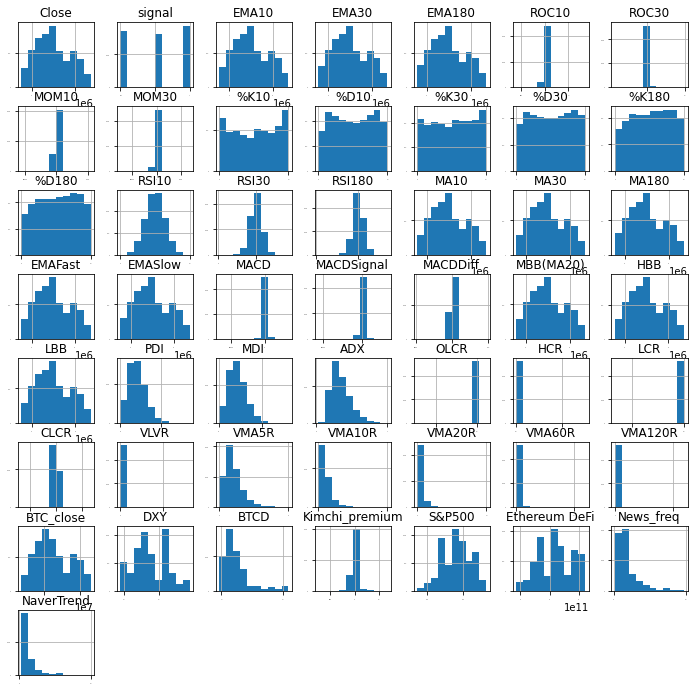

In [103]:
# 히스토그램 그리기

dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

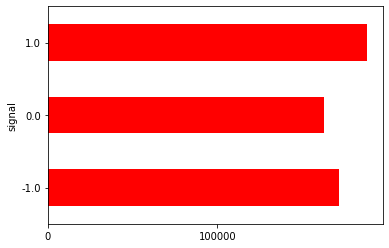

In [104]:
# label 개수 시각화

fig =plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.rc('font', size=50)
plt.show()

In [105]:
# feature correlation 표현

correlation = dataset.corr()
plt.figure(figsize=(300,300))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')